In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '20 days LSTM Time Series Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Cyclic Stocks

### Singapore Airlines

In [8]:
nr_test_sets = ['C6L.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1
 
    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2018-12-14         9.52  9.466080 -53.571343 -82078567.0     2.0
2018-12-17         9.33  9.445145 -87.500043 -84305791.0     2.0
2018-12-18         9.45  9.445892 -64.814890 -82764591.0     2.0
2018-12-19         9.39  9.437293 -75.925903 -84460291.0     2.0
2018-12-20         9.37  9.426940 -75.000054 -85913091.0     2.0


In [9]:
r_test_sets = ['C6L.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-12-16         9.13  9.083831 -44.117515 -5009999.0     2.0
2019-12-17         9.12  9.089395 -43.750019 -5679099.0     2.0
2019-12-18         9.12  9.094104 -33.333333 -5679099.0     2.0
2019-12-19         9.12  9.098088 -33.333333 -5679099.0     2.0
2019-12-20         9.05  9.090690 -57.692110 -6968099.0     1.0


### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


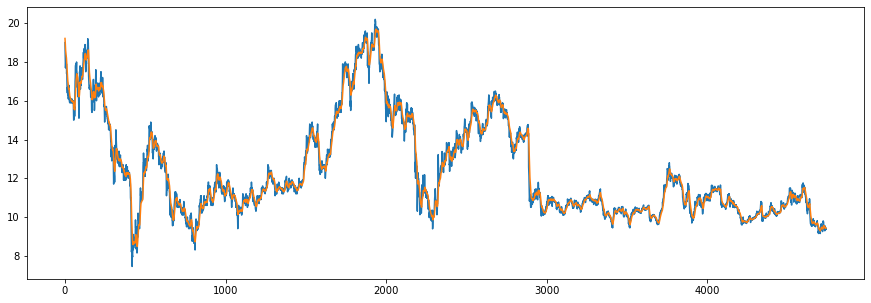

In [10]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/C6L.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 20, 4)
y = labels
y = np.array(y)

In [11]:
from collections import Counter

Counter(y)

Counter({2.0: 4292, 0.0: 215, 1.0: 213})

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('C6L.SI')]
    y = nr_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('C6L.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('C6L.SI')]
    y = r_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('C6L.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.317829457364341, 1: 7.403921568627451, 2: 0.36653077072413126}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 31ms/step - loss: 0.2947 - accuracy: 0.5193 - mse: 0.4515 - weighted_accuracy: 0.3278 - weighted_mse: 0.5263 - val_loss: 0.2992 - val_accuracy: 0.0456 - val_mse: 0.3563 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.3563
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2120 - accuracy: 0.3700 - mse: 0.7932 - weighted_accuracy: 0.4063 - weighted_mse: 0.7713 - val_loss: 0.2903 - val_accuracy: 0.0456 - val_mse: 0.3869 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.3869
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1924 - accuracy: 0.3223 - mse: 1.0298 - weighted_accuracy: 0.4478 - weighted_mse: 0.9935 - val_loss: 0.2810 - val_accuracy: 0.0456 - val_mse: 0.4265 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.4265
Epoch 4/20
30/30 [==============================] - 0s 7

7/7 [==============================] - 0s 3ms/step - loss: 0.1954 - accuracy: 0.2837 - mse: 1.3112 - weighted_accuracy: 0.2837 - weighted_mse: 1.3112


<ipython-input-16-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.1953750103712082
Test accuracy: 0.2837209403514862


number of predictions: 215
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 88
actual holds but predicted sell: 58
actual predicted holds: 52
Percentage buys correct: 4.301075268817204%
Percentage sells correct: 7.8125%
Percentage holds correct: 89.65517241379311%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.31182795698925%
Percentage high sells correct: 54.6875%
Percentage mid holds correct: 82.45614035087719%


Capital: 100
Share price: $0.9726168574149023
Shares owned at the moment: 102
Cash capital at the moment: $0.5202615151750791


Price increase from previously bought: -47.803767832477675%
Share price: $0.5090654437174831
Shares owned at the moment: 0
Cash capital at the moment: $52.3021439173956


Share pri

Epoch 16/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1350 - accuracy: 0.4335 - mse: 1.6505 - weighted_accuracy: 0.7221 - weighted_mse: 1.5773 - val_loss: 0.1844 - val_accuracy: 0.4248 - val_mse: 1.6533 - val_weighted_accuracy: 0.4248 - val_weighted_mse: 1.6533
Epoch 17/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1346 - accuracy: 0.4425 - mse: 1.6786 - weighted_accuracy: 0.7272 - weighted_mse: 1.6124 - val_loss: 0.1814 - val_accuracy: 0.4333 - val_mse: 1.7144 - val_weighted_accuracy: 0.4333 - val_weighted_mse: 1.7144
Epoch 18/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1331 - accuracy: 0.4447 - mse: 1.6766 - weighted_accuracy: 0.7299 - weighted_mse: 1.6033 - val_loss: 0.1877 - val_accuracy: 0.3919 - val_mse: 1.8092 - val_weighted_accuracy: 0.3919 - val_weighted_mse: 1.8092
Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1321 - accuracy: 0.4576 - mse: 1.7084 - weighted_accuracy: 0.7421 - weighted

<ipython-input-16-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu


30/30 [==============================] - 0s 8ms/step - loss: 0.1300 - accuracy: 0.4428 - mse: 1.7529 - weighted_accuracy: 0.7459 - weighted_mse: 1.6789 - val_loss: 0.1873 - val_accuracy: 0.4036 - val_mse: 1.8092 - val_weighted_accuracy: 0.4036 - val_weighted_mse: 1.8092
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1287 - accuracy: 0.4799 - mse: 1.7395 - weighted_accuracy: 0.7595 - weighted_mse: 1.6748 - val_loss: 0.1775 - val_accuracy: 0.4597 - val_mse: 1.8012 - val_weighted_accuracy: 0.4597 - val_weighted_mse: 1.8012
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1285 - accuracy: 0.4674 - mse: 1.7563 - weighted_accuracy: 0.7549 - weighted_mse: 1.6852 - val_loss: 0.1850 - val_accuracy: 0.4248 - val_mse: 1.8734 - val_weighted_accuracy: 0.4248 - val_weighted_mse: 1.8734
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1274 - accuracy: 0.4944 - mse: 1.7730 - weighted_accuracy: 0.7519 - weighted_mse: 1.7166 -

7/7 [==============================] - 0s 3ms/step - loss: 0.1866 - accuracy: 0.4977 - mse: 2.2509 - weighted_accuracy: 0.4977 - weighted_mse: 2.2509
Test loss: 0.18656501173973083
Test accuracy: 0.4976744055747986


number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 61
actual holds but predicted sell: 37
actual predicted holds: 100
Percentage buys correct: 4.6875%
Percentage sells correct: 9.75609756097561%
Percentage holds correct: 90.9090909090909%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 43.75%
Percentage high sells correct: 60.97560975609756%
Percentage mid holds correct: 85.3211009174312%


Capital: 100
Share price: $0.9726168574149023
Shares owned at the moment: 102
Cash capital at the moment: $0.5202615151750791


Price increase from previously bo

<ipython-input-16-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 8ms/step - loss: 0.1132 - accuracy: 0.5580 - mse: 2.0899 - weighted_accuracy: 0.8011 - weighted_mse: 2.0557 - val_loss: 0.1780 - val_accuracy: 0.4947 - val_mse: 2.2019 - val_weighted_accuracy: 0.4947 - val_weighted_mse: 2.2019
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1114 - accuracy: 0.5853 - mse: 2.0796 - weighted_accuracy: 0.8055 - weighted_mse: 2.0518 - val_loss: 0.1670 - val_accuracy: 0.5625 - val_mse: 2.1882 - val_weighted_accuracy: 0.5625 - val_weighted_mse: 2.1882
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1123 - accuracy: 0.5683 - mse: 2.1011 - weighted_accuracy: 0.8085 - weighted_mse: 2.0621 - val_loss: 0.1725 - val_accuracy: 0.5339 - val_mse: 2.2221 - val_weighted_accuracy: 0.5339 - val_weighted_mse: 2.2221
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1102 - accuracy: 0.5967 - mse: 2.1254 - weighted_accuracy: 0.8097 - weighted_mse: 2.1131 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1869 - accuracy: 0.5953 - mse: 2.7694 - weighted_accuracy: 0.5953 - weighted_mse: 2.7694
Test loss: 0.18692441284656525
Test accuracy: 0.5953488349914551


number of predictions: 215
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 58
actual holds but predicted sell: 17
actual predicted holds: 123
Percentage buys correct: 6.451612903225806%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 91.11111111111111%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 45.16129032258065%
Percentage high sells correct: 61.111111111111114%
Percentage mid holds correct: 83.58208955223881%


Capital: 100
Share price: $0.9614018255109305
Shares owned at the moment: 103
Cash capital at the moment: $0.7032949052981934


Price 

<ipython-input-16-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 9ms/step - loss: 0.0969 - accuracy: 0.6491 - mse: 2.5736 - weighted_accuracy: 0.8511 - weighted_mse: 2.5827 - val_loss: 0.1750 - val_accuracy: 0.5720 - val_mse: 2.7261 - val_weighted_accuracy: 0.5720 - val_weighted_mse: 2.7261
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0948 - accuracy: 0.6825 - mse: 2.5461 - weighted_accuracy: 0.8578 - weighted_mse: 2.5595 - val_loss: 0.1632 - val_accuracy: 0.6430 - val_mse: 2.7306 - val_weighted_accuracy: 0.6430 - val_weighted_mse: 2.7306
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0951 - accuracy: 0.6613 - mse: 2.5794 - weighted_accuracy: 0.8592 - weighted_mse: 2.5838 - val_loss: 0.1780 - val_accuracy: 0.5667 - val_mse: 2.8065 - val_weighted_accuracy: 0.5667 - val_weighted_mse: 2.8065
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0931 - accuracy: 0.6907 - mse: 2.6356 - weighted_accuracy: 0.8589 - weighted_mse: 2.6646 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1863 - accuracy: 0.6047 - mse: 3.4914 - weighted_accuracy: 0.6047 - weighted_mse: 3.4914
Test loss: 0.18625140190124512
Test accuracy: 0.604651153087616


number of predictions: 215
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 55
actual holds but predicted sell: 17
actual predicted holds: 126
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 0.0%
Percentage holds correct: 91.30434782608695%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 45.0%
Percentage high sells correct: 52.94117647058823%
Percentage mid holds correct: 83.94160583941606%


Capital: 100
Share price: $0.8997195956812989
Shares owned at the moment: 110
Cash capital at the moment: $0.7586792973635283


Price increase from previously boug

<ipython-input-16-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0817 - accuracy: 0.7278 - mse: 3.1914 - weighted_accuracy: 0.8799 - weighted_mse: 3.2275 - val_loss: 0.1897 - val_accuracy: 0.5763 - val_mse: 3.3694 - val_weighted_accuracy: 0.5763 - val_weighted_mse: 3.3694
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0793 - accuracy: 0.7484 - mse: 3.1596 - weighted_accuracy: 0.8967 - weighted_mse: 3.1927 - val_loss: 0.1732 - val_accuracy: 0.6695 - val_mse: 3.4154 - val_weighted_accuracy: 0.6695 - val_weighted_mse: 3.4154
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0794 - accuracy: 0.7317 - mse: 3.1727 - weighted_accuracy: 0.8906 - weighted_mse: 3.1899 - val_loss: 0.1778 - val_accuracy: 0.6155 - val_mse: 3.5054 - val_weighted_accuracy: 0.6155 - val_weighted_mse: 3.5054
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0775 - accuracy: 0.7558 - mse: 3.2748 - weighted_accuracy: 0.8976 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1884 - accuracy: 0.6465 - mse: 4.5058 - weighted_accuracy: 0.6465 - weighted_mse: 4.5058
Test loss: 0.18844185769557953
Test accuracy: 0.6465116143226624


number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 43
actual holds but predicted sell: 18
actual predicted holds: 137
Percentage buys correct: 4.3478260869565215%
Percentage sells correct: 0.0%
Percentage holds correct: 90.72847682119205%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.82608695652174%
Percentage high sells correct: 38.888888888888886%
Percentage mid holds correct: 82.0%


Capital: 100
Share price: $0.8118691660420985
Shares owned at the moment: 122
Cash capital at the moment: $0.6795796376568575


Price increase from previously b

<ipython-input-16-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu


30/30 [==============================] - 0s 8ms/step - loss: 0.0679 - accuracy: 0.7858 - mse: 4.0209 - weighted_accuracy: 0.9067 - weighted_mse: 4.0397 - val_loss: 0.1966 - val_accuracy: 0.6176 - val_mse: 4.2326 - val_weighted_accuracy: 0.6176 - val_weighted_mse: 4.2326
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0665 - accuracy: 0.7963 - mse: 3.9896 - weighted_accuracy: 0.9179 - weighted_mse: 4.0058 - val_loss: 0.1906 - val_accuracy: 0.6621 - val_mse: 4.1486 - val_weighted_accuracy: 0.6621 - val_weighted_mse: 4.1486
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0657 - accuracy: 0.7918 - mse: 3.9652 - weighted_accuracy: 0.9219 - weighted_mse: 3.9679 - val_loss: 0.1764 - val_accuracy: 0.6864 - val_mse: 4.5051 - val_weighted_accuracy: 0.6864 - val_weighted_mse: 4.5051
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0633 - accuracy: 0.8141 - mse: 4.1274 - weighted_accuracy: 0.9263 - weighted_mse: 4.1327 -

7/7 [==============================] - 0s 3ms/step - loss: 0.1793 - accuracy: 0.7116 - mse: 5.6497 - weighted_accuracy: 0.7116 - weighted_mse: 5.6497
Test loss: 0.17927424609661102
Test accuracy: 0.7116279006004333


number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 32
actual holds but predicted sell: 14
actual predicted holds: 152
Percentage buys correct: 3.0303030303030303%
Percentage sells correct: 0.0%
Percentage holds correct: 90.47619047619048%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 60.60606060606061%
Percentage high sells correct: 42.857142857142854%
Percentage mid holds correct: 82.63473053892216%


Capital: 100
Share price: $0.8118691660420985
Shares owned at the moment: 122
Cash capital at the moment: $0.6795796376568575


Price increase from

<ipython-input-16-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 9ms/step - loss: 0.0570 - accuracy: 0.8302 - mse: 5.0555 - weighted_accuracy: 0.9267 - weighted_mse: 4.9918 - val_loss: 0.2177 - val_accuracy: 0.6335 - val_mse: 5.1923 - val_weighted_accuracy: 0.6335 - val_weighted_mse: 5.1923
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0557 - accuracy: 0.8398 - mse: 5.0275 - weighted_accuracy: 0.9394 - weighted_mse: 4.9569 - val_loss: 0.2099 - val_accuracy: 0.6769 - val_mse: 5.1354 - val_weighted_accuracy: 0.6769 - val_weighted_mse: 5.1354
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0550 - accuracy: 0.8329 - mse: 4.9536 - weighted_accuracy: 0.9369 - weighted_mse: 4.8744 - val_loss: 0.1910 - val_accuracy: 0.7214 - val_mse: 5.8857 - val_weighted_accuracy: 0.7214 - val_weighted_mse: 5.8857
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0519 - accuracy: 0.8514 - mse: 5.1907 - weighted_accuracy: 0.9437 - weighted_mse: 5.0966 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1783 - accuracy: 0.7302 - mse: 6.7879 - weighted_accuracy: 0.7302 - weighted_mse: 6.7879
Test loss: 0.17828957736492157
Test accuracy: 0.7302325367927551


number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 32
actual holds but predicted sell: 10
actual predicted holds: 156
Percentage buys correct: 3.0303030303030303%
Percentage sells correct: 0.0%
Percentage holds correct: 90.69767441860465%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 60.60606060606061%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 83.04093567251462%


Capital: 100
Share price: $0.8118691660420985
Shares owned at the moment: 122
Cash capital at the moment: $0.6795796376568575


Price increase from previously bo

<ipython-input-16-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu


30/30 [==============================] - 0s 8ms/step - loss: 0.0472 - accuracy: 0.8633 - mse: 6.2418 - weighted_accuracy: 0.9444 - weighted_mse: 6.0141 - val_loss: 0.2235 - val_accuracy: 0.7034 - val_mse: 6.5357 - val_weighted_accuracy: 0.7034 - val_weighted_mse: 6.5357
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0459 - accuracy: 0.8776 - mse: 6.2750 - weighted_accuracy: 0.9533 - weighted_mse: 6.0471 - val_loss: 0.2196 - val_accuracy: 0.7087 - val_mse: 6.4923 - val_weighted_accuracy: 0.7087 - val_weighted_mse: 6.4923
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0453 - accuracy: 0.8702 - mse: 6.1723 - weighted_accuracy: 0.9524 - weighted_mse: 5.9241 - val_loss: 0.2101 - val_accuracy: 0.7542 - val_mse: 7.6085 - val_weighted_accuracy: 0.7542 - val_weighted_mse: 7.6085
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0433 - accuracy: 0.8808 - mse: 6.4860 - weighted_accuracy: 0.9545 - weighted_mse: 6.2079 -

7/7 [==============================] - 0s 3ms/step - loss: 0.1846 - accuracy: 0.7581 - mse: 8.1348 - weighted_accuracy: 0.7581 - weighted_mse: 8.1348
Test loss: 0.18458740413188934
Test accuracy: 0.7581395506858826




<ipython-input-16-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 25
actual holds but predicted sell: 11
actual predicted holds: 162
Percentage buys correct: 3.8461538461538463%
Percentage sells correct: 0.0%
Percentage holds correct: 91.01123595505618%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 61.53846153846154%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 83.61581920903954%


Capital: 100
Share price: $0.5352336435270513
Shares owned at the moment: 186
Cash capital at the moment: $0.1727702953043604


Price increase from previously bought: -5.149954765299814%
Share price: $0.5090654437174831
Shares owned at the moment: 0
Cash capital at the moment: $94.59855585229472


Share price: $0.16700937711429376
Shares owned at the moment: 564


<ipython-input-16-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [17]:
df = nr_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.279817,7.317073,7.228916,92.452830,53.658537,48.192771,80.769231,-58.833740,-64.1546
1,0.279817,5.882353,8.974359,89.090909,48.235294,50.000000,77.777778,-74.659962,-64.1546
2,0.467890,7.843137,8.955224,92.000000,54.901961,50.746269,81.818182,-63.937845,-64.1546
3,0.513761,9.090909,7.843137,91.964286,56.363636,49.019608,81.981982,-32.817002,-64.1546
4,0.564220,10.000000,6.976744,92.000000,56.000000,53.488372,81.451613,-1.655239,-64.1546
5,0.600917,9.756098,7.142857,91.851852,58.536585,50.000000,81.343284,-8.118981,-64.1546
6,0.660550,10.344828,5.263158,92.052980,55.172414,44.736842,81.333333,-56.001523,-64.1546
7,0.711009,13.636364,3.225806,91.515152,50.000000,41.935484,81.097561,-40.963652,-64.1546
8,0.729358,15.000000,6.451613,92.215569,50.000000,48.387097,81.927711,4.567638,-64.1546
9,0.756881,11.111111,0.000000,91.061453,55.555556,42.857143,80.898876,121.028180,-64.1546


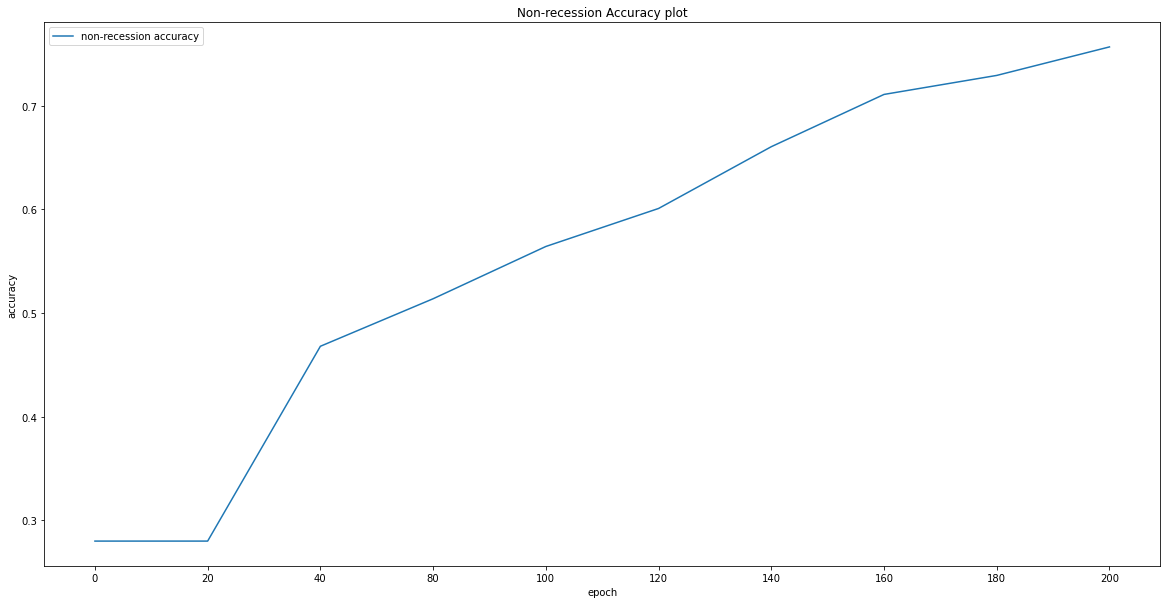

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

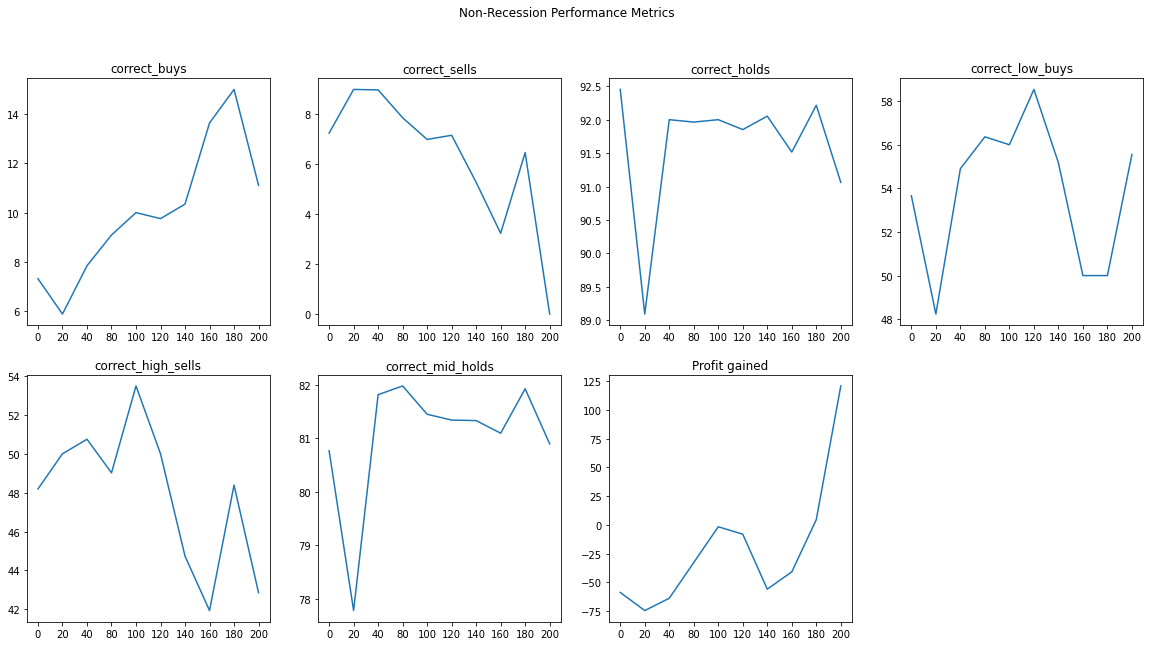

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

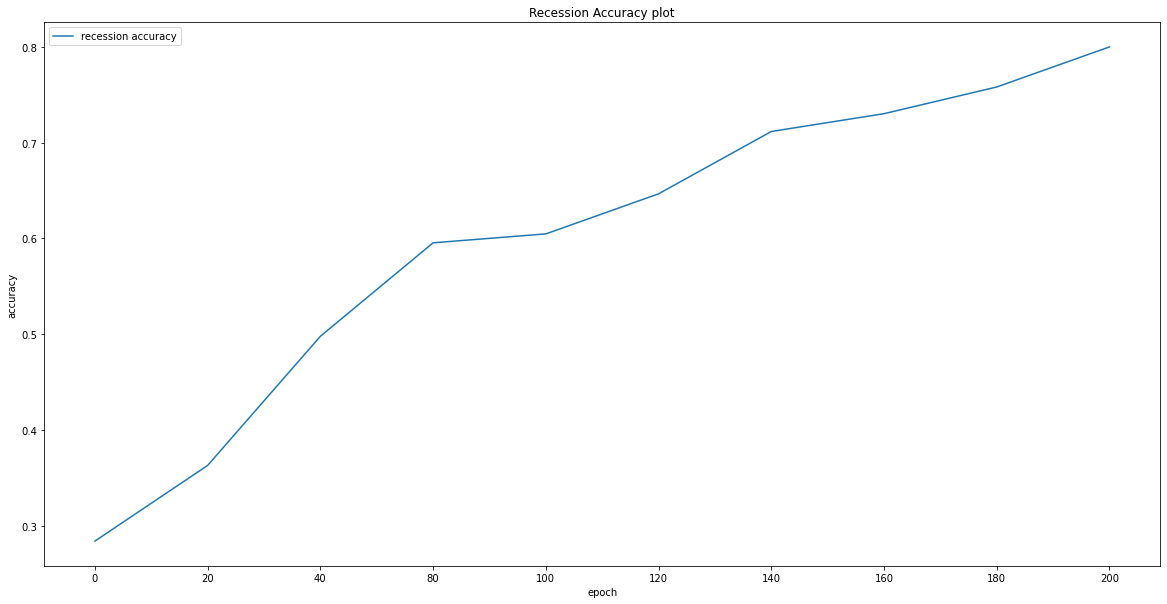

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

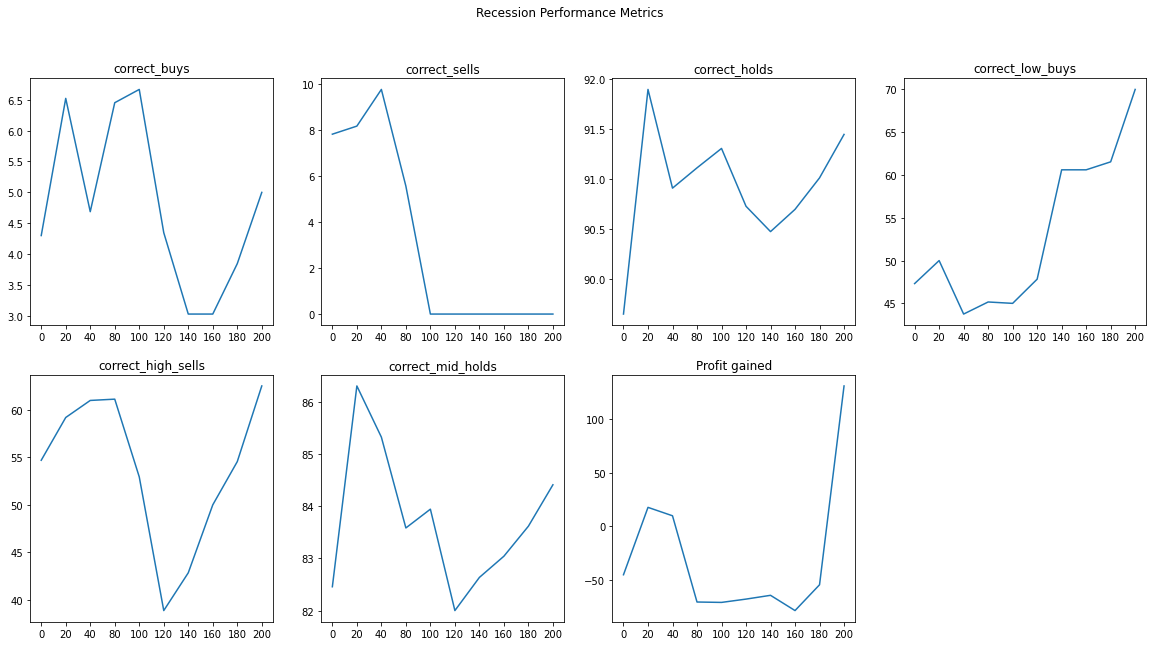

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### OCBC Bank

In [22]:
nr_test_sets = ['O39.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-12-14        11.29  11.223146 -41.249981  448131022.0     2.0
2018-12-17        11.12  11.207277 -80.645176  443153122.0     0.0
2018-12-18        11.34  11.227696 -45.161256  448093822.0     2.0
2018-12-19        11.15  11.215743 -75.806509  440428782.0     2.0
2018-12-20        11.14  11.204090 -77.419295  435151482.0     2.0


In [23]:
r_test_sets = ['O39.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1
    

    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-12-16        10.97  10.791319 -18.367351  53474942.0     2.0
2019-12-17        10.91  10.809578 -30.612316  49577542.0     2.0
2019-12-18        10.89  10.821951 -34.693842  45681342.0     2.0
2019-12-19        10.96  10.843189 -20.408211  50188142.0     2.0
2019-12-20        10.95  10.859621 -22.449071  47197442.0     2.0


### training Data

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


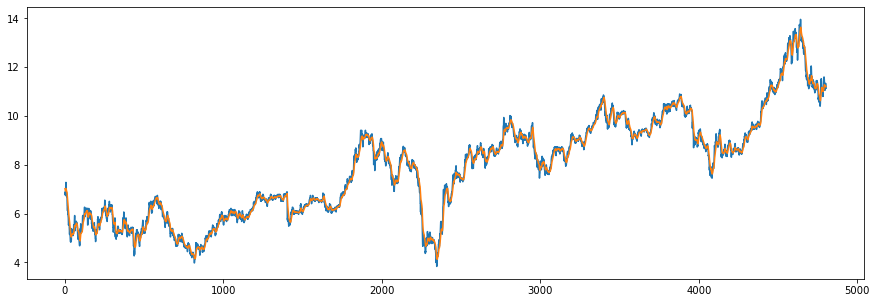

In [24]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/O39.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1   
    
X  = np.array(sequential).reshape(-1, 20, 4)
y = labels
y = np.array(y)

In [25]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [26]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [27]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('O39.SI')]
    y = nr_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('O39.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('O39.SI')]
    y = r_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('O39.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.2481060606060606, 1: 7.923395445134576, 2: 0.3655205348615091}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 30ms/step - loss: 0.2898 - accuracy: 0.5236 - mse: 0.4498 - weighted_accuracy: 0.3575 - weighted_mse: 0.5255 - val_loss: 0.2987 - val_accuracy: 0.0418 - val_mse: 0.3552 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3552
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2089 - accuracy: 0.3768 - mse: 0.7892 - weighted_accuracy: 0.4354 - weighted_mse: 0.7713 - val_loss: 0.2892 - val_accuracy: 0.0418 - val_mse: 0.3851 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3851
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1881 - accuracy: 0.3109 - mse: 1.0543 - weighted_accuracy: 0.4849 - weighted_mse: 1.0041 - val_loss: 0.2771 - val_accuracy: 0.0418 - val_mse: 0.4212 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.4212
Epoch 4/20
30/30 [==============================] - 0s 8

7/7 [==============================] - 0s 3ms/step - loss: 0.1747 - accuracy: 0.4465 - mse: 1.2657 - weighted_accuracy: 0.4465 - weighted_mse: 1.2657


<ipython-input-29-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.17467814683914185
Test accuracy: 0.4465116262435913


number of predictions: 215
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 68
actual holds but predicted sell: 35
actual predicted holds: 90
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 85.71428571428571%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 56.94444444444444%
Percentage high sells correct: 51.351351351351354%
Percentage mid holds correct: 81.9047619047619%


Capital: 100
Share price: $0.9581707117622773
Shares owned at the moment: 104
Cash capital at the moment: $0.0762091531591409


Price increase from previously bought: -77.38179406913402%
Share price: $0.2173170075737143
Shares owned at the moment: 0
Cash capital at the moment: $22.6

<ipython-input-29-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1239 - accuracy: 0.4923 - mse: 1.9552 - weighted_accuracy: 0.7483 - weighted_mse: 1.9082 - val_loss: 0.1979 - val_accuracy: 0.4013 - val_mse: 2.0689 - val_weighted_accuracy: 0.4013 - val_weighted_mse: 2.0689
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1229 - accuracy: 0.4706 - mse: 1.9875 - weighted_accuracy: 0.7617 - weighted_mse: 1.9240 - val_loss: 0.2018 - val_accuracy: 0.3730 - val_mse: 1.9551 - val_weighted_accuracy: 0.3730 - val_weighted_mse: 1.9551
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1221 - accuracy: 0.4868 - mse: 1.9964 - weighted_accuracy: 0.7619 - weighted_mse: 1.9141 - val_loss: 0.1884 - val_accuracy: 0.4357 - val_mse: 2.0460 - val_weighted_accuracy: 0.4357 - val_weighted_mse: 2.0460
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1220 - accuracy: 0.4993 - mse: 2.0270 - weighted_accuracy: 0.7631 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1740 - accuracy: 0.5535 - mse: 2.2744 - weighted_accuracy: 0.5535 - weighted_mse: 2.2744
Test loss: 0.17403684556484222
Test accuracy: 0.5534883737564087


number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 60
actual holds but predicted sell: 19
actual predicted holds: 114
Percentage buys correct: 4.761904761904762%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 87.6923076923077%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.94573643410853%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price increase from

<ipython-input-29-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 8ms/step - loss: 0.1070 - accuracy: 0.5971 - mse: 2.4414 - weighted_accuracy: 0.8096 - weighted_mse: 2.4201 - val_loss: 0.1833 - val_accuracy: 0.5057 - val_mse: 2.5196 - val_weighted_accuracy: 0.5057 - val_weighted_mse: 2.5196
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1050 - accuracy: 0.5796 - mse: 2.4695 - weighted_accuracy: 0.8145 - weighted_mse: 2.4299 - val_loss: 0.2010 - val_accuracy: 0.4556 - val_mse: 2.4395 - val_weighted_accuracy: 0.4556 - val_weighted_mse: 2.4395
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1039 - accuracy: 0.5918 - mse: 2.5069 - weighted_accuracy: 0.8262 - weighted_mse: 2.4484 - val_loss: 0.1844 - val_accuracy: 0.4901 - val_mse: 2.6485 - val_weighted_accuracy: 0.4901 - val_weighted_mse: 2.6485
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1043 - accuracy: 0.5895 - mse: 2.5663 - weighted_accuracy: 0.8239 - weighted_mse: 2.5381 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.2000 - accuracy: 0.5116 - mse: 2.8220 - weighted_accuracy: 0.5116 - weighted_mse: 2.8220
Test loss: 0.1999744474887848
Test accuracy: 0.5116279125213623


number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 68
actual holds but predicted sell: 20
actual predicted holds: 105
Percentage buys correct: 4.166666666666667%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 88.23529411764706%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.611111111111114%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 83.05084745762711%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Pric

<ipython-input-29-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 8ms/step - loss: 0.0909 - accuracy: 0.6773 - mse: 3.0900 - weighted_accuracy: 0.8501 - weighted_mse: 3.0658 - val_loss: 0.1925 - val_accuracy: 0.5402 - val_mse: 3.1327 - val_weighted_accuracy: 0.5402 - val_weighted_mse: 3.1327
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0883 - accuracy: 0.6650 - mse: 3.1169 - weighted_accuracy: 0.8607 - weighted_mse: 3.0826 - val_loss: 0.1931 - val_accuracy: 0.5455 - val_mse: 3.0124 - val_weighted_accuracy: 0.5455 - val_weighted_mse: 3.0124
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0884 - accuracy: 0.6731 - mse: 3.1832 - weighted_accuracy: 0.8676 - weighted_mse: 3.1159 - val_loss: 0.1937 - val_accuracy: 0.5162 - val_mse: 3.4623 - val_weighted_accuracy: 0.5162 - val_weighted_mse: 3.4623
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0884 - accuracy: 0.6684 - mse: 3.2618 - weighted_accuracy: 0.8617 - weighted_mse: 3.2397 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.2103 - accuracy: 0.5209 - mse: 3.6831 - weighted_accuracy: 0.5209 - weighted_mse: 3.6831
Test loss: 0.2102719396352768
Test accuracy: 0.5209302306175232


number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 2
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 65
actual holds but predicted sell: 19
actual predicted holds: 109
Percentage buys correct: 2.9411764705882355%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 87.2%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 45.45454545454545%
Percentage mid holds correct: 83.06451612903226%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price increase fro

<ipython-input-29-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 8ms/step - loss: 0.0769 - accuracy: 0.7366 - mse: 3.9774 - weighted_accuracy: 0.8847 - weighted_mse: 3.8890 - val_loss: 0.2056 - val_accuracy: 0.5726 - val_mse: 4.0263 - val_weighted_accuracy: 0.5726 - val_weighted_mse: 4.0263
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0740 - accuracy: 0.7361 - mse: 4.0095 - weighted_accuracy: 0.8868 - weighted_mse: 3.9101 - val_loss: 0.2102 - val_accuracy: 0.5434 - val_mse: 4.0409 - val_weighted_accuracy: 0.5434 - val_weighted_mse: 4.0409
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0743 - accuracy: 0.7421 - mse: 4.0690 - weighted_accuracy: 0.8984 - weighted_mse: 3.9192 - val_loss: 0.2040 - val_accuracy: 0.5705 - val_mse: 4.4130 - val_weighted_accuracy: 0.5705 - val_weighted_mse: 4.4130
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0741 - accuracy: 0.7418 - mse: 4.1720 - weighted_accuracy: 0.8983 - weighted_mse: 4.0852 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.2097 - accuracy: 0.6047 - mse: 4.8248 - weighted_accuracy: 0.6047 - weighted_mse: 4.8248
Test loss: 0.20969481766223907
Test accuracy: 0.604651153087616


number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 48
actual holds but predicted sell: 18
actual predicted holds: 127
Percentage buys correct: 3.9215686274509802%
Percentage sells correct: 5.0%
Percentage holds correct: 88.19444444444444%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 45.0%
Percentage mid holds correct: 83.91608391608392%


Capital: 100
Share price: $0.8057316971229416
Shares owned at the moment: 123
Cash capital at the moment: $0.622462507326361


Price increase from previously bo

<ipython-input-29-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 9ms/step - loss: 0.0642 - accuracy: 0.7907 - mse: 5.1196 - weighted_accuracy: 0.9122 - weighted_mse: 4.8900 - val_loss: 0.2179 - val_accuracy: 0.6228 - val_mse: 5.2043 - val_weighted_accuracy: 0.6228 - val_weighted_mse: 5.2043
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0611 - accuracy: 0.7881 - mse: 5.1615 - weighted_accuracy: 0.9116 - weighted_mse: 4.9200 - val_loss: 0.2157 - val_accuracy: 0.6228 - val_mse: 5.4442 - val_weighted_accuracy: 0.6228 - val_weighted_mse: 5.4442
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0622 - accuracy: 0.7983 - mse: 5.2372 - weighted_accuracy: 0.9171 - weighted_mse: 4.9469 - val_loss: 0.2195 - val_accuracy: 0.5946 - val_mse: 5.5760 - val_weighted_accuracy: 0.5946 - val_weighted_mse: 5.5760
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0617 - accuracy: 0.7988 - mse: 5.3300 - weighted_accuracy: 0.9191 - weighted_mse: 5.1028 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.2481 - accuracy: 0.6093 - mse: 5.9809 - weighted_accuracy: 0.6093 - weighted_mse: 5.9809
Test loss: 0.24807341396808624
Test accuracy: 0.6093023419380188


number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 48
actual holds but predicted sell: 17
actual predicted holds: 128
Percentage buys correct: 2.0%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 87.67123287671232%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.0%
Percentage high sells correct: 52.63157894736842%
Percentage mid holds correct: 83.44827586206897%


Capital: 100
Share price: $0.8545121352868346

<ipython-input-29-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu


Shares owned at the moment: 116
Cash capital at the moment: $0.6040029355706906


Price increase from previously bought: -60.049933873187776%
Share price: $0.3423169530572745
Shares owned at the moment: 0
Cash capital at the moment: $40.20357038218926


Share price: $0.3301218435163016
Shares owned at the moment: 121
Cash capital at the moment: $0.14897927328672012


Price increase from previously bought: 2.4888146546291123%
Share price: $0.3392683937377907
Shares owned at the moment: 0
Cash capital at the moment: $41.08756335754315


Share price: $0.2539023361966335
Shares owned at the moment: 161
Cash capital at the moment: $0.09687197053409591


Price increase from previously bought: 89.53644238281913%
Share price: $0.4825608581556373
Shares owned at the moment: 0
Cash capital at the moment: $77.5755163136433


Share price: $0.4307315699179155
Shares owned at the moment: 179
Cash capital at the moment: $0.2625376830443287


Price increase from previously bought: -0.980067961292963%

Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0423 - accuracy: 0.8686 - mse: 7.8001 - weighted_accuracy: 0.9520 - weighted_mse: 7.0389 - val_loss: 0.2083 - val_accuracy: 0.7544 - val_mse: 8.9750 - val_weighted_accuracy: 0.7544 - val_weighted_mse: 8.9750
Epoch 20/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0426 - accuracy: 0.8790 - mse: 8.0444 - weighted_accuracy: 0.9518 - weighted_mse: 7.3201 - val_loss: 0.2789 - val_accuracy: 0.6531 - val_mse: 8.1480 - val_weighted_accuracy: 0.6531 - val_weighted_mse: 8.1480
Validation loss: 0.2788914740085602
Validation accuracy: 0.653082549571991


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2511 - accuracy: 0.6239 - mse: 10.1207 - weighted_accuracy: 0.6239 - weighted_mse: 10.1207
Test loss: 0.25107547640800476
Test accuracy: 0.6238532066345215


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold:

<ipython-input-29-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 8ms/step - loss: 0.0444 - accuracy: 0.8725 - mse: 8.1325 - weighted_accuracy: 0.9476 - weighted_mse: 7.3088 - val_loss: 0.2518 - val_accuracy: 0.6719 - val_mse: 8.6987 - val_weighted_accuracy: 0.6719 - val_weighted_mse: 8.6987
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0432 - accuracy: 0.8660 - mse: 8.1939 - weighted_accuracy: 0.9456 - weighted_mse: 7.3866 - val_loss: 0.2427 - val_accuracy: 0.6938 - val_mse: 8.7967 - val_weighted_accuracy: 0.6938 - val_weighted_mse: 8.7967
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0439 - accuracy: 0.8785 - mse: 8.2609 - weighted_accuracy: 0.9518 - weighted_mse: 7.3766 - val_loss: 0.2279 - val_accuracy: 0.6991 - val_mse: 8.5688 - val_weighted_accuracy: 0.6991 - val_weighted_mse: 8.5688
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0430 - accuracy: 0.8699 - mse: 8.3541 - weighted_accuracy: 0.9470 - weighted_mse: 7.5492 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.3293 - accuracy: 0.6651 - mse: 9.2853 - weighted_accuracy: 0.6651 - weighted_mse: 9.2853
Test loss: 0.32931187748908997
Test accuracy: 0.6651162505149841


number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 40
actual holds but predicted sell: 13
actual predicted holds: 140
Percentage buys correct: 2.380952380952381%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 88.60759493670886%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 84.71337579617834%


Capital: 100
Share price: $0.8545121352868346
Shares owned at the moment: 116
Cash capital at the moment: $0.6040029355706906


Pr

<ipython-input-29-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu


30/30 [==============================] - 0s 8ms/step - loss: 0.0367 - accuracy: 0.8981 - mse: 9.9301 - weighted_accuracy: 0.9590 - weighted_mse: 8.6442 - val_loss: 0.2771 - val_accuracy: 0.6959 - val_mse: 10.6626 - val_weighted_accuracy: 0.6959 - val_weighted_mse: 10.6626
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0363 - accuracy: 0.8952 - mse: 9.9628 - weighted_accuracy: 0.9599 - weighted_mse: 8.7052 - val_loss: 0.2658 - val_accuracy: 0.7022 - val_mse: 10.5584 - val_weighted_accuracy: 0.7022 - val_weighted_mse: 10.5584
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0366 - accuracy: 0.9049 - mse: 10.0374 - weighted_accuracy: 0.9633 - weighted_mse: 8.7070 - val_loss: 0.2421 - val_accuracy: 0.7273 - val_mse: 10.8019 - val_weighted_accuracy: 0.7273 - val_weighted_mse: 10.8019
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0362 - accuracy: 0.8981 - mse: 10.1285 - weighted_accuracy: 0.9592 - weighted_mse: 

7/7 [==============================] - 0s 3ms/step - loss: 0.3615 - accuracy: 0.6791 - mse: 11.1009 - weighted_accuracy: 0.6791 - weighted_mse: 11.1009
Test loss: 0.3615057170391083
Test accuracy: 0.6790697574615479


number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 36
actual holds but predicted sell: 13
actual predicted holds: 144
Percentage buys correct: 2.7027027027027026%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 87.8048780487805%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 56.75675675675676%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 84.04907975460122%


Capital: 100
Share price: $0.8545121352868346
Shares owned at the moment: 116
Cash capital at the moment: $0.6040029355706906


Pr

<ipython-input-29-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [30]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.446512,5.555556,5.263158,85.714286,56.944444,51.351351,81.904762,-67.779613,-24.56292
1,0.497674,6.153846,5.882353,87.068966,53.846154,51.515152,84.482759,-46.178798,-24.56292
2,0.553488,4.761905,9.090909,87.692308,52.380952,50.000000,82.945736,-56.082971,-24.56292
3,0.511628,4.166667,8.333333,88.235294,48.611111,54.166667,83.050847,-52.026597,-24.56292
4,0.520930,2.941176,4.545455,87.200000,47.058824,45.454545,83.064516,-58.512398,-24.56292
5,0.604651,3.921569,5.000000,88.194444,47.058824,45.000000,83.916084,-48.795607,-24.56292
6,0.609302,2.000000,10.526316,87.671233,48.000000,52.631579,83.448276,22.739732,-24.56292
7,0.641860,4.166667,12.500000,88.741722,50.000000,56.250000,84.666667,6.447586,-24.56292
8,0.665116,2.380952,13.333333,88.607595,52.380952,53.333333,84.713376,50.240754,-24.56292
9,0.679070,2.702703,7.142857,87.804878,56.756757,57.142857,84.049080,48.290352,-24.56292


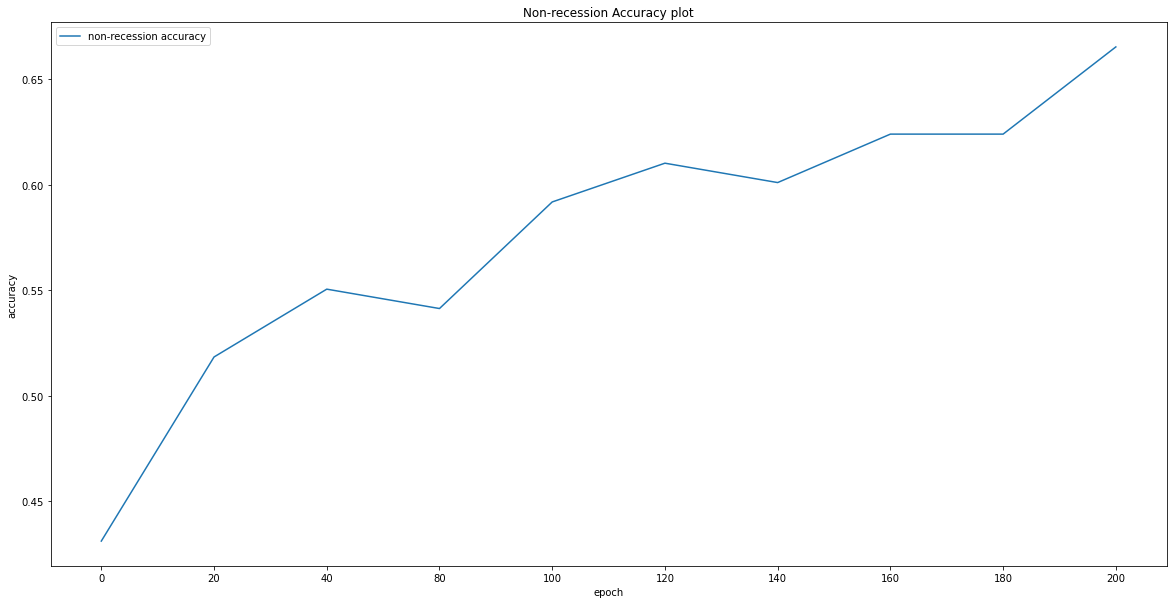

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

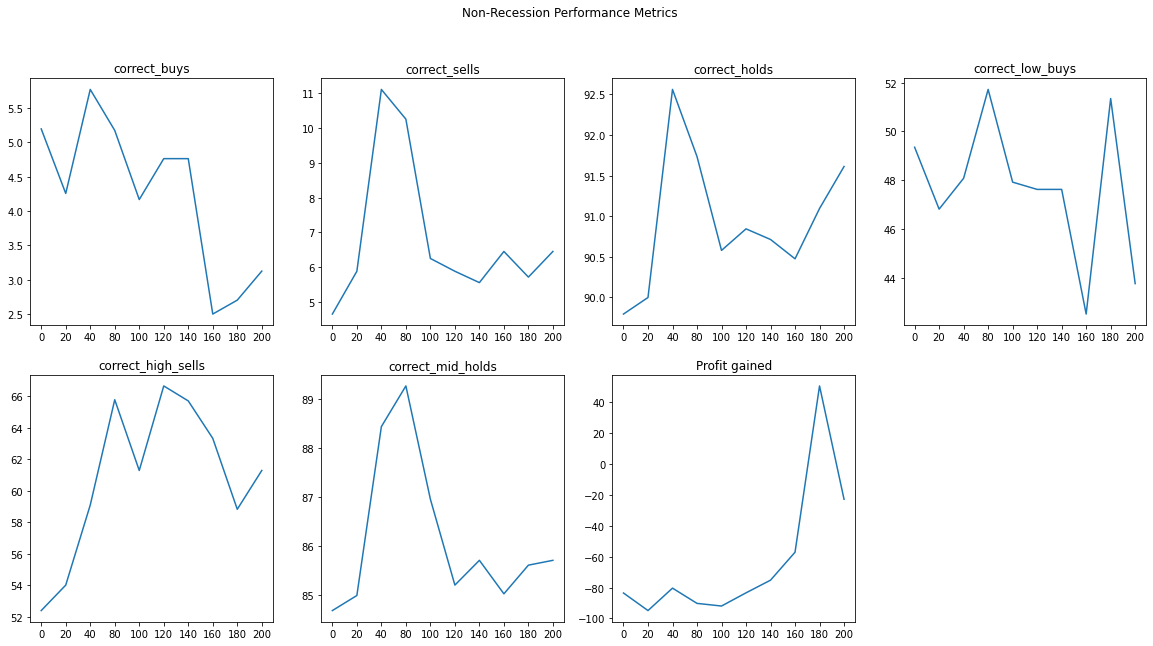

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

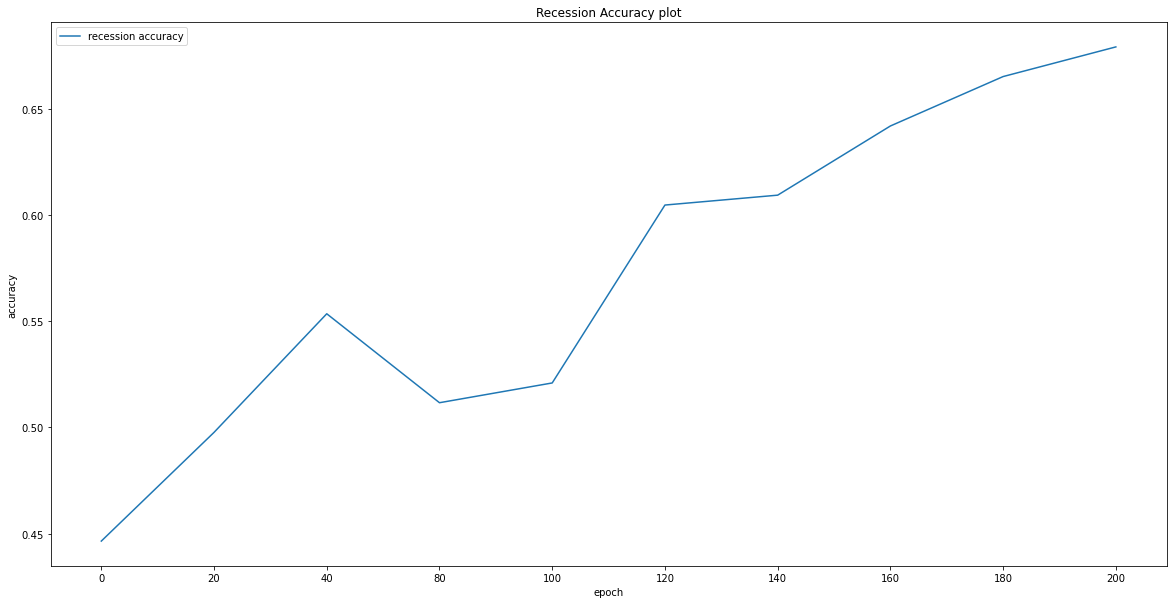

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

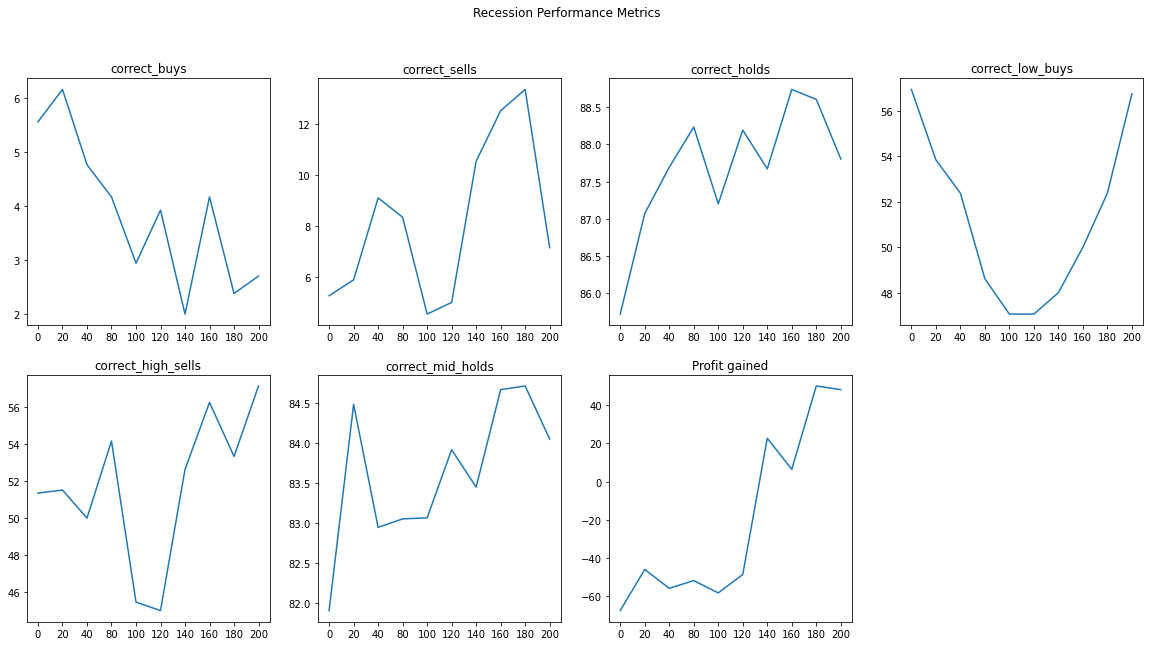

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### CNOOC Limited

In [35]:
nr_test_sets = ['0883.HK']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1
    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2018-12-12        12.74  13.032944 -77.906974  9.460210e+09     2.0
2018-12-13        12.74  12.987876 -77.906974  9.460210e+09     2.0
2018-12-14        13.06  12.998972 -59.302288  9.506982e+09     2.0
2018-12-17        12.80  12.968361 -78.048748  9.447852e+09     2.0
2018-12-18        12.68  12.923998 -95.890382  9.410332e+09     2.0


In [36]:
r_test_sets = ['0883.HK']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1
     
        
    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-12-12        11.36  11.447620 -75.000025 -214227973.0     2.0
2019-12-13        11.46  11.449525 -64.583319 -167306085.0     2.0
2019-12-16        11.78  11.500367 -31.250019  -82839244.0     2.0
2019-12-17        11.74  11.537234 -31.111168 -127828316.0     2.0
2019-12-18        12.06  11.617659  -5.999947  -67007162.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


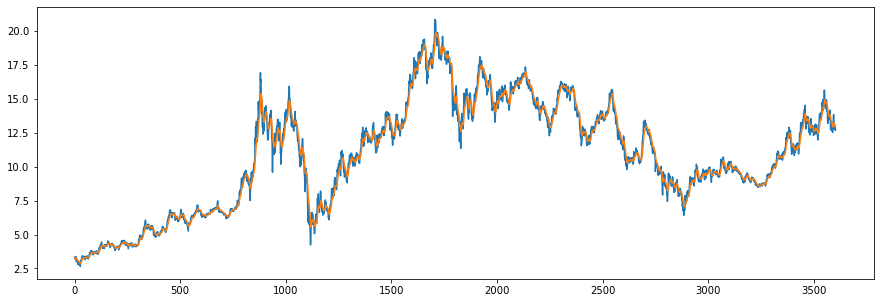

In [37]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/0883.HK_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

    
X  = np.array(sequential).reshape(-1, 20, 4)
y = labels
y = np.array(y)

In [38]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [39]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [40]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [42]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('0883.HK')]
    y = nr_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('0883.HK'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('0883.HK')]
    y = r_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('0883.HK'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.242424242424242, 1: 7.3538461538461535, 2: 0.3668457405986186}



RUNNING EPOCHS 0 - 20



Epoch 1/20
23/23 [==============================] - 1s 40ms/step - loss: 0.3015 - accuracy: 0.5558 - mse: 0.4134 - weighted_accuracy: 0.3277 - weighted_mse: 0.5031 - val_loss: 0.3009 - val_accuracy: 0.0474 - val_mse: 0.3508 - val_weighted_accuracy: 0.0474 - val_weighted_mse: 0.3508
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 0.2206 - accuracy: 0.4236 - mse: 0.6748 - weighted_accuracy: 0.4096 - weighted_mse: 0.6812 - val_loss: 0.2942 - val_accuracy: 0.0446 - val_mse: 0.3705 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3705
Epoch 3/20
23/23 [==============================] - 0s 8ms/step - loss: 0.1946 - accuracy: 0.3734 - mse: 0.8855 - weighted_accuracy: 0.4585 - weighted_mse: 0.8751 - val_loss: 0.2866 - val_accuracy: 0.0446 - val_mse: 0.3972 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3972
Epoch 4/20
23/23 [==============================] - 0s 8

7/7 [==============================] - 0s 3ms/step - loss: 0.1981 - accuracy: 0.2582 - mse: 1.2123 - weighted_accuracy: 0.2582 - weighted_mse: 1.2123


<ipython-input-42-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.19805671274662018
Test accuracy: 0.2582159638404846


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 6
actual predicted sells: 2
actual sells but predicted hold: 2
actual holds but predicted buy: 131
actual holds but predicted sell: 16
actual predicted holds: 46
Percentage buys correct: 4.861111111111111%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 90.19607843137256%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 40.55944055944056%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 78.43137254901961%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -2.9338626685874836%
Share price: $0.9830639990116465
Shares owned at the moment: 0
Cash capital at the moment: $96.82314115540771


number of predictions: 211
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 77
actual holds but predicted sell: 49
actual predicted holds: 68
Percentage buys correct: 2.5316455696202533%
Percentage sells correct: 9.25925925925926%
Percentage holds correct: 87.17948717948718%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 51.89873417721519%
Percentage high sells correct: 64.15094339622641%
Percentage mid holds correct: 75.64102564102564%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.016758900191504722


Price increase from previously bought: -15.335307812045896%
Share price: $0.5758537640591352
Shares owned at the moment: 0
Cash capital at the moment: $84.43447333276347


Share price: $0.9221952138579563
Shares owned at th

<ipython-input-42-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu





RUNNING EPOCHS 40 - 60



Epoch 1/20
23/23 [==============================] - 0s 8ms/step - loss: 0.1254 - accuracy: 0.4794 - mse: 1.7779 - weighted_accuracy: 0.7680 - weighted_mse: 1.7255 - val_loss: 0.1758 - val_accuracy: 0.4603 - val_mse: 1.8072 - val_weighted_accuracy: 0.4603 - val_weighted_mse: 1.8072
Epoch 2/20
23/23 [==============================] - 0s 7ms/step - loss: 0.1241 - accuracy: 0.4777 - mse: 1.7890 - weighted_accuracy: 0.7529 - weighted_mse: 1.7446 - val_loss: 0.1735 - val_accuracy: 0.5035 - val_mse: 1.7555 - val_weighted_accuracy: 0.5035 - val_weighted_mse: 1.7555
Epoch 3/20
23/23 [==============================] - 0s 7ms/step - loss: 0.1224 - accuracy: 0.5112 - mse: 1.8066 - weighted_accuracy: 0.7772 - weighted_mse: 1.7701 - val_loss: 0.1822 - val_accuracy: 0.4477 - val_mse: 1.8904 - val_weighted_accuracy: 0.4477 - val_weighted_mse: 1.8904
Epoch 4/20
23/23 [==============================] - 0s 7ms/step - loss: 0.1229 - accuracy: 0.5007 - mse: 1.8506 - weighted_a

7/7 [==============================] - 0s 3ms/step - loss: 0.1640 - accuracy: 0.5915 - mse: 2.1050 - weighted_accuracy: 0.5915 - weighted_mse: 2.1050
Test loss: 0.16402721405029297
Test accuracy: 0.591549277305603




<ipython-input-42-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 213
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 55
actual holds but predicted sell: 20
actual predicted holds: 118
Percentage buys correct: 6.557377049180328%
Percentage sells correct: 16.0%
Percentage holds correct: 92.91338582677166%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 44.26229508196721%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.03937007874016%


Capital: 100
Share price: $0.9897979992587349
Shares owned at the moment: 100
Cash capital at the moment: $0.7480056243303466


Price increase from previously bought: -27.413280427809017%
Share price: $0.7204376682727409
Shares owned at the moment: 0
Cash capital at the moment: $72.59365209282944


Share price: $0.2473737093989017
Shares owned at the moment: 292
Cash capita

Epoch 17/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0934 - accuracy: 0.6890 - mse: 2.4664 - weighted_accuracy: 0.8642 - weighted_mse: 2.5072 - val_loss: 0.1667 - val_accuracy: 0.5858 - val_mse: 2.5013 - val_weighted_accuracy: 0.5858 - val_weighted_mse: 2.5013
Epoch 18/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0950 - accuracy: 0.6827 - mse: 2.5254 - weighted_accuracy: 0.8643 - weighted_mse: 2.5609 - val_loss: 0.1670 - val_accuracy: 0.5844 - val_mse: 2.5164 - val_weighted_accuracy: 0.5844 - val_weighted_mse: 2.5164
Epoch 19/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0924 - accuracy: 0.6768 - mse: 2.5506 - weighted_accuracy: 0.8597 - weighted_mse: 2.5984 - val_loss: 0.1602 - val_accuracy: 0.6067 - val_mse: 2.6035 - val_weighted_accuracy: 0.6067 - val_weighted_mse: 2.6035
Epoch 20/20
23/23 [==============================] - 0s 7ms/step - loss: 0.0922 - accuracy: 0.6642 - mse: 2.5690 - weighted_accuracy: 0.8503 - weighted

<ipython-input-42-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0902 - accuracy: 0.6980 - mse: 2.5628 - weighted_accuracy: 0.8772 - weighted_mse: 2.6068 - val_loss: 0.1695 - val_accuracy: 0.5718 - val_mse: 2.7096 - val_weighted_accuracy: 0.5718 - val_weighted_mse: 2.7096
Epoch 2/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0893 - accuracy: 0.6987 - mse: 2.6022 - weighted_accuracy: 0.8774 - weighted_mse: 2.6577 - val_loss: 0.1501 - val_accuracy: 0.6597 - val_mse: 2.6727 - val_weighted_accuracy: 0.6597 - val_weighted_mse: 2.6727
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0880 - accuracy: 0.7123 - mse: 2.6518 - weighted_accuracy: 0.8727 - weighted_mse: 2.7016 - val_loss: 0.1680 - val_accuracy: 0.5690 - val_mse: 2.7355 - val_weighted_accuracy: 0.5690 - val_weighted_mse: 2.7355
Epoch 4/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0891 - accuracy: 0.6865 - mse: 2.6666 - weighted_accuracy: 0.8657 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1254 - accuracy: 0.7887 - mse: 3.1341 - weighted_accuracy: 0.7887 - weighted_mse: 3.1341
Test loss: 0.12540961802005768
Test accuracy: 0.7887324094772339


number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 26
actual holds but predicted sell: 6
actual predicted holds: 161
Percentage buys correct: 10.344827586206897%
Percentage sells correct: 40.0%
Percentage holds correct: 92.52873563218391%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 37.93103448275862%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 84.39306358381504%


Capital: 100
Share price: $0.9897979992587349
Shares owned at the moment: 100
Cash capital at the moment: $0.7480056243303466


Price increase from previously 

<ipython-input-42-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu




RUNNING EPOCHS 100 - 120



Epoch 1/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0751 - accuracy: 0.7695 - mse: 3.1619 - weighted_accuracy: 0.9082 - weighted_mse: 3.2176 - val_loss: 0.1775 - val_accuracy: 0.6151 - val_mse: 3.2600 - val_weighted_accuracy: 0.6151 - val_weighted_mse: 3.2600
Epoch 2/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0732 - accuracy: 0.7660 - mse: 3.2084 - weighted_accuracy: 0.9093 - weighted_mse: 3.2685 - val_loss: 0.1552 - val_accuracy: 0.6862 - val_mse: 3.3380 - val_weighted_accuracy: 0.6862 - val_weighted_mse: 3.3380
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0734 - accuracy: 0.7789 - mse: 3.2896 - weighted_accuracy: 0.9068 - weighted_mse: 3.3354 - val_loss: 0.1721 - val_accuracy: 0.6234 - val_mse: 3.3819 - val_weighted_accuracy: 0.6234 - val_weighted_mse: 3.3819
Epoch 4/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0743 - accuracy: 0.7626 - mse: 3.3177 - weighted_

<ipython-input-42-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

23/23 [==============================] - 0s 9ms/step - loss: 0.0622 - accuracy: 0.8117 - mse: 3.9573 - weighted_accuracy: 0.9237 - weighted_mse: 3.9629 - val_loss: 0.1894 - val_accuracy: 0.6276 - val_mse: 4.0096 - val_weighted_accuracy: 0.6276 - val_weighted_mse: 4.0096
Epoch 2/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0597 - accuracy: 0.8211 - mse: 3.9862 - weighted_accuracy: 0.9295 - weighted_mse: 3.9927 - val_loss: 0.1635 - val_accuracy: 0.7141 - val_mse: 4.2874 - val_weighted_accuracy: 0.7141 - val_weighted_mse: 4.2874
Epoch 3/20
23/23 [==============================] - 0s 7ms/step - loss: 0.0600 - accuracy: 0.8218 - mse: 4.0855 - weighted_accuracy: 0.9274 - weighted_mse: 4.0729 - val_loss: 0.1885 - val_accuracy: 0.6346 - val_mse: 4.1142 - val_weighted_accuracy: 0.6346 - val_weighted_mse: 4.1142
Epoch 4/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0615 - accuracy: 0.8082 - mse: 4.0975 - weighted_accuracy: 0.9200 - weighted_mse: 4.1022 - 

<ipython-input-42-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0518 - accuracy: 0.8487 - mse: 4.9578 - weighted_accuracy: 0.9372 - weighted_mse: 4.8282 - val_loss: 0.2148 - val_accuracy: 0.6332 - val_mse: 5.0337 - val_weighted_accuracy: 0.6332 - val_weighted_mse: 5.0337
Epoch 2/20
23/23 [==============================] - 0s 7ms/step - loss: 0.0494 - accuracy: 0.8584 - mse: 4.9728 - weighted_accuracy: 0.9432 - weighted_mse: 4.8333 - val_loss: 0.1758 - val_accuracy: 0.7350 - val_mse: 5.4221 - val_weighted_accuracy: 0.7350 - val_weighted_mse: 5.4221
Epoch 3/20
23/23 [==============================] - 0s 7ms/step - loss: 0.0497 - accuracy: 0.8490 - mse: 5.0856 - weighted_accuracy: 0.9398 - weighted_mse: 4.9060 - val_loss: 0.2029 - val_accuracy: 0.6722 - val_mse: 5.2119 - val_weighted_accuracy: 0.6722 - val_weighted_mse: 5.2119
Epoch 4/20
23/23 [==============================] - 0s 7ms/step - loss: 0.0514 - accuracy: 0.8459 - mse: 5.0868 - weighted_accuracy: 0.9338 - weighted_mse

<ipython-input-42-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

23/23 [==============================] - 0s 20ms/step - loss: 0.0425 - accuracy: 0.8780 - mse: 6.1177 - weighted_accuracy: 0.9528 - weighted_mse: 5.7224 - val_loss: 0.2445 - val_accuracy: 0.6318 - val_mse: 5.9351 - val_weighted_accuracy: 0.6318 - val_weighted_mse: 5.9351
Epoch 2/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0413 - accuracy: 0.8863 - mse: 6.1422 - weighted_accuracy: 0.9511 - weighted_mse: 5.7505 - val_loss: 0.1898 - val_accuracy: 0.7601 - val_mse: 6.6193 - val_weighted_accuracy: 0.7601 - val_weighted_mse: 6.6193
Epoch 3/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0415 - accuracy: 0.8752 - mse: 6.2497 - weighted_accuracy: 0.9494 - weighted_mse: 5.8170 - val_loss: 0.2241 - val_accuracy: 0.6862 - val_mse: 6.3516 - val_weighted_accuracy: 0.6862 - val_weighted_mse: 6.3516
Epoch 4/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0422 - accuracy: 0.8783 - mse: 6.2893 - weighted_accuracy: 0.9457 - weighted_mse: 5.8744 -

<ipython-input-42-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0351 - accuracy: 0.9024 - mse: 7.4529 - weighted_accuracy: 0.9594 - weighted_mse: 6.7077 - val_loss: 0.2513 - val_accuracy: 0.6695 - val_mse: 7.1514 - val_weighted_accuracy: 0.6695 - val_weighted_mse: 7.1514
Epoch 2/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0348 - accuracy: 0.9055 - mse: 7.5330 - weighted_accuracy: 0.9605 - weighted_mse: 6.7991 - val_loss: 0.2096 - val_accuracy: 0.7782 - val_mse: 8.1596 - val_weighted_accuracy: 0.7782 - val_weighted_mse: 8.1596
Epoch 3/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0347 - accuracy: 0.8975 - mse: 7.6365 - weighted_accuracy: 0.9624 - weighted_mse: 6.8360 - val_loss: 0.2395 - val_accuracy: 0.7085 - val_mse: 7.6854 - val_weighted_accuracy: 0.7085 - val_weighted_mse: 7.6854
Epoch 4/20
23/23 [==============================] - 0s 7ms/step - loss: 0.0354 - accuracy: 0.9045 - mse: 7.6277 - weighted_accuracy: 0.9577 - weighted_ms

number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 8
actual holds but predicted sell: 4
actual predicted holds: 181
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 92.34693877551021%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 54.54545454545455%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.1025641025641%


Capital: 100
Share price: $0.26757571014016657
Shares owned at the moment: 372
Cash capital at the moment: $0.18810587638463971


Price increase from previously bought: 75.0189173856216%
Share price: $0.4695959583796625
Shares owned at the moment: 0
Cash capital at the moment: $174.39740572819667


Share price: $0.38205379461628364
Shares owned at the moment: 45

<ipython-input-42-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

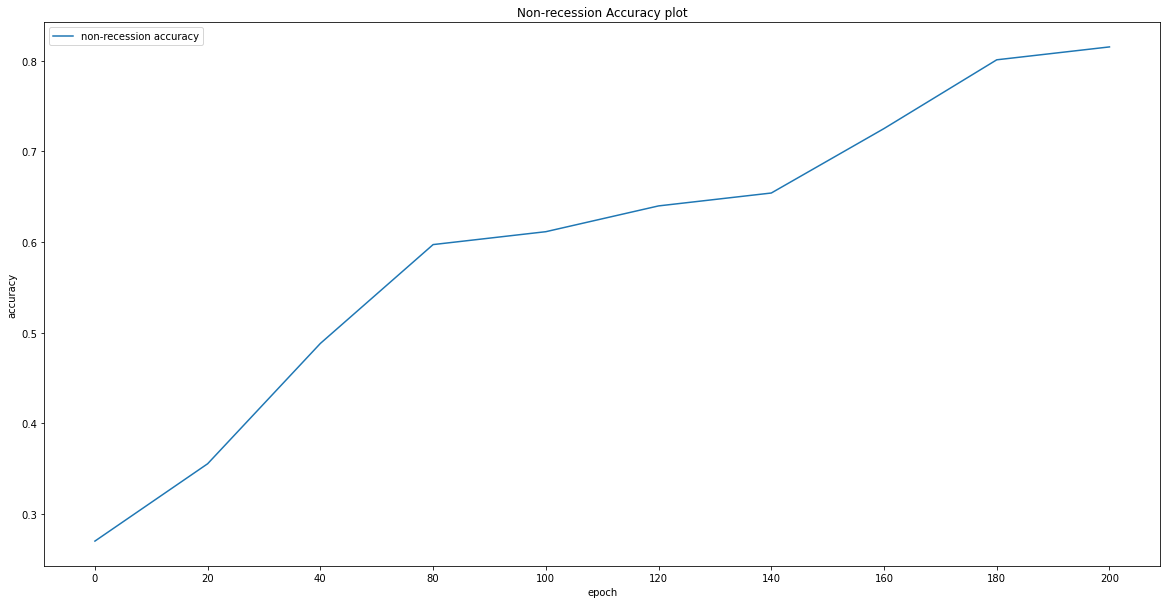

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

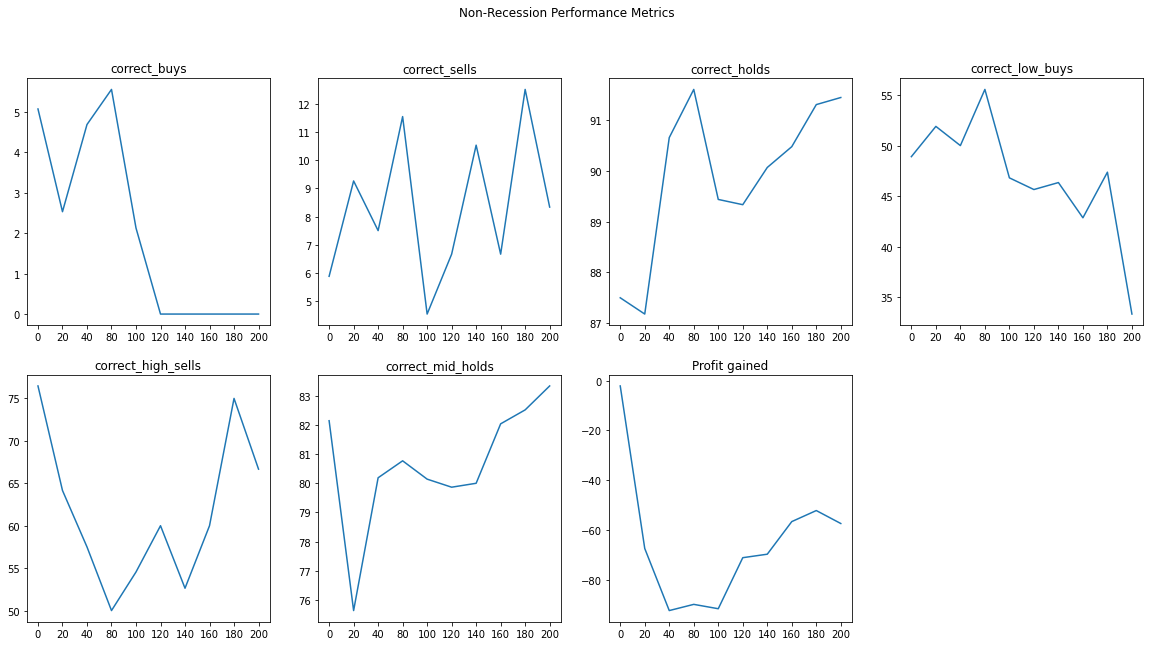

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

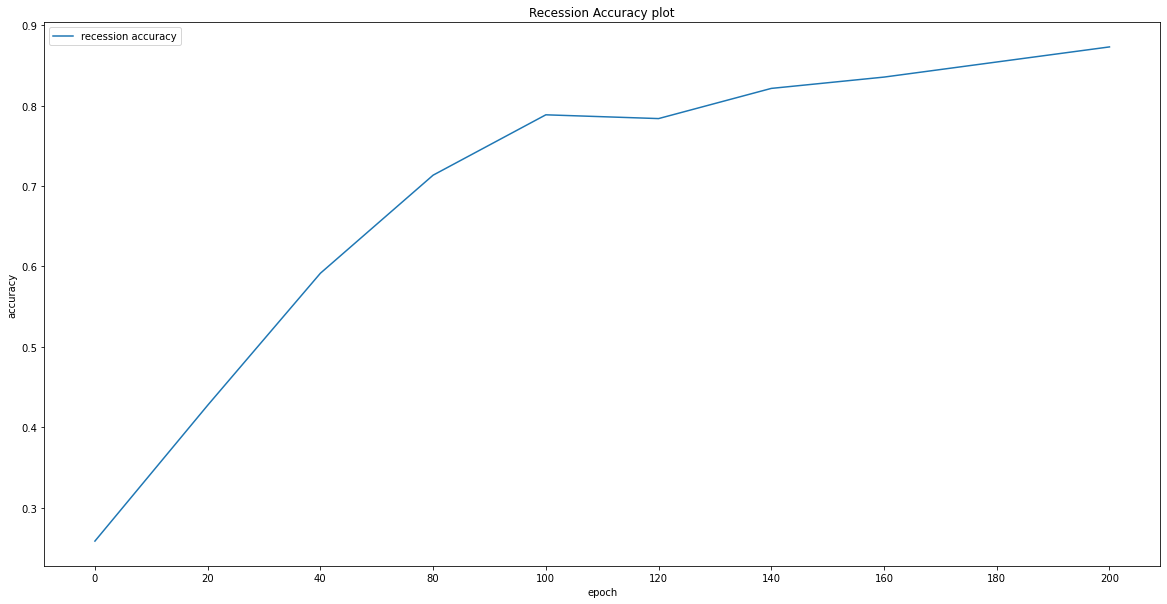

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

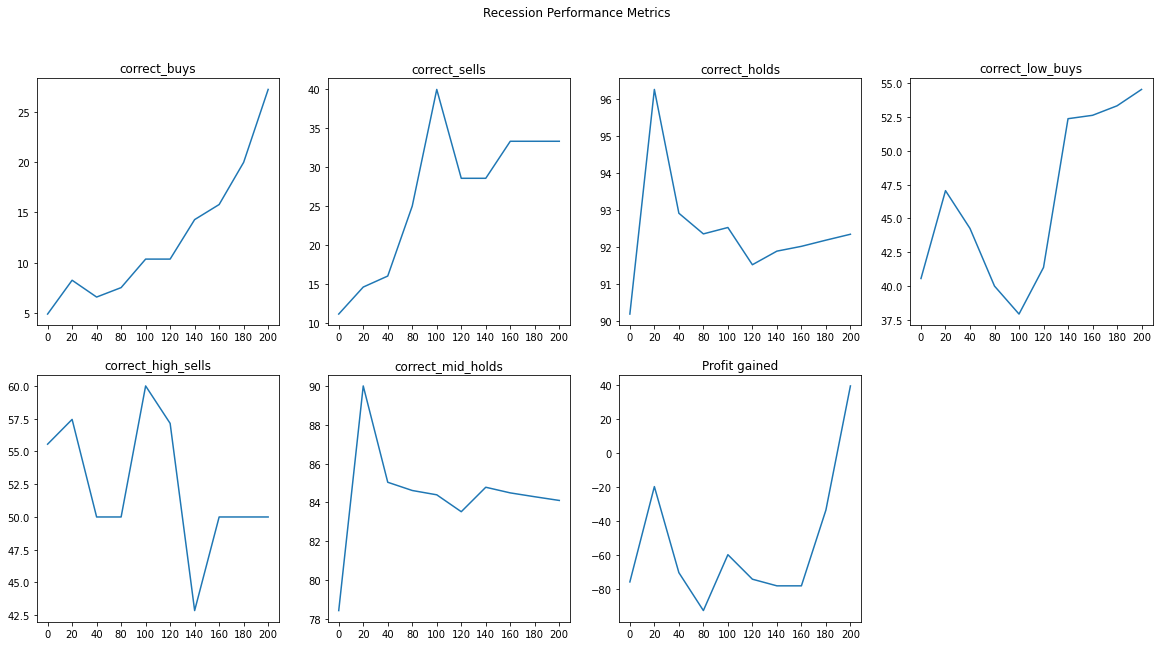

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### JP Morgan

In [47]:
nr_test_sets = ['JPM']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14         OBV_7  labels
Date                                                                
2018-12-13   101.019997  105.247250 -87.215299 -1.989079e+09     2.0
2018-12-14   101.120003  104.612289 -86.480500 -1.971828e+09     2.0
2018-12-17   100.290001  103.947322 -92.578971 -1.991708e+09     2.0
2018-12-18    99.010002  103.187734 -96.055365 -2.016821e+09     2.0
2018-12-19    98.540001  102.472698 -97.156410 -2.037658e+09     2.0


In [48]:
r_test_sets = ['JPM']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2019-12-13   138.020004  133.597310  -4.554623  284280700.0     2.0
2019-12-16   136.809998  134.091570 -19.726594  273688600.0     2.0
2019-12-17   137.339996  134.591328 -14.634146  285060600.0     2.0
2019-12-18   138.179993  135.143430  -6.439060  296607400.0     2.0
2019-12-19   138.039993  135.589055  -9.396071  286225900.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


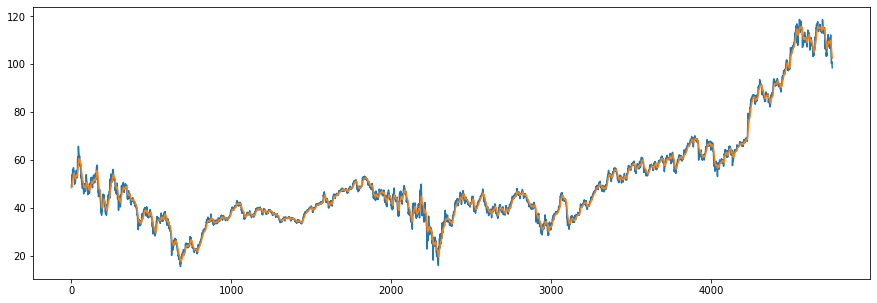

In [49]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/JPM_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 20, 4)
y = labels
y = np.array(y)

In [50]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [51]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [52]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [54]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('JPM')]
    y = nr_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('JPM'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('JPM')]
    y = r_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('JPM'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[0 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.7073170731707314, 1: 7.391812865497076, 2: 0.3656349435927104}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 30ms/step - loss: 0.2925 - accuracy: 0.5053 - mse: 0.4752 - weighted_accuracy: 0.3107 - weighted_mse: 0.5497 - val_loss: 0.2987 - val_accuracy: 0.0475 - val_mse: 0.3540 - val_weighted_accuracy: 0.0475 - val_weighted_mse: 0.3540
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2117 - accuracy: 0.3747 - mse: 0.7722 - weighted_accuracy: 0.4209 - weighted_mse: 0.7731 - val_loss: 0.2900 - val_accuracy: 0.0454 - val_mse: 0.3857 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3857
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1921 - accuracy: 0.2869 - mse: 1.0202 - weighted_accuracy: 0.4739 - weighted_mse: 0.9886 - val_loss: 0.2806 - val_accuracy: 0.0454 - val_mse: 0.4275 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.4275
Epoch 4/20
30/30 [==============================] - 0s 7

7/7 [==============================] - 0s 3ms/step - loss: 0.1838 - accuracy: 0.3333 - mse: 1.3356 - weighted_accuracy: 0.3333 - weighted_mse: 1.3356


<ipython-input-54-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.1837647706270218
Test accuracy: 0.3333333432674408


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 93
actual holds but predicted sell: 45
actual predicted holds: 59
Percentage buys correct: 7.766990291262136%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 90.76923076923077%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 62.745098039215684%
Percentage mid holds correct: 81.53846153846153%


Capital: 100
Share price: $0.9728624318115608
Shares owned at the moment: 102
Cash capital at the moment: $0.49514404309763904


Price increase from previously bought: -77.94149562446839%
Share price: $0.21518904906980119
Shares owned at the moment: 0
Cash capital at the moment: $22

Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1336 - accuracy: 0.4283 - mse: 1.8174 - weighted_accuracy: 0.7320 - weighted_mse: 1.7062 - val_loss: 0.1936 - val_accuracy: 0.3639 - val_mse: 1.8733 - val_weighted_accuracy: 0.3639 - val_weighted_mse: 1.8733
Epoch 17/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1317 - accuracy: 0.4462 - mse: 1.8290 - weighted_accuracy: 0.7307 - weighted_mse: 1.7407 - val_loss: 0.2019 - val_accuracy: 0.3692 - val_mse: 1.8077 - val_weighted_accuracy: 0.3692 - val_weighted_mse: 1.8077
Epoch 18/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1309 - accuracy: 0.4256 - mse: 1.8629 - weighted_accuracy: 0.7444 - weighted_mse: 1.7486 - val_loss: 0.1871 - val_accuracy: 0.3755 - val_mse: 1.8901 - val_weighted_accuracy: 0.3755 - val_weighted_mse: 1.8901
Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1298 - accuracy: 0.4428 - mse: 1.8678 - weighted_accuracy: 0.7428 - weighted

<ipython-input-54-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1291 - accuracy: 0.4444 - mse: 1.9084 - weighted_accuracy: 0.7435 - weighted_mse: 1.8102 - val_loss: 0.1796 - val_accuracy: 0.4314 - val_mse: 1.8433 - val_weighted_accuracy: 0.4314 - val_weighted_mse: 1.8433
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1260 - accuracy: 0.4836 - mse: 1.8986 - weighted_accuracy: 0.7637 - weighted_mse: 1.8075 - val_loss: 0.1930 - val_accuracy: 0.3903 - val_mse: 1.9399 - val_weighted_accuracy: 0.3903 - val_weighted_mse: 1.9399
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1276 - accuracy: 0.4599 - mse: 1.9434 - weighted_accuracy: 0.7510 - weighted_mse: 1.8379 - val_loss: 0.2044 - val_accuracy: 0.3407 - val_mse: 2.0393 - val_weighted_accuracy: 0.3407 - val_weighted_mse: 2.0393
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1259 - accuracy: 0.4681 - mse: 2.0016 - weighted_accuracy: 0.7654 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1710 - accuracy: 0.5023 - mse: 2.2559 - weighted_accuracy: 0.5023 - weighted_mse: 2.2559
Test loss: 0.17101454734802246
Test accuracy: 0.5022830963134766


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 51
actual holds but predicted sell: 44
actual predicted holds: 102
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 8.16326530612245%
Percentage holds correct: 89.47368421052632%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 48.214285714285715%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 80.70175438596492%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price increase from 

<ipython-input-54-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu





RUNNING EPOCHS 60 - 80



Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1125 - accuracy: 0.5578 - mse: 2.3257 - weighted_accuracy: 0.8057 - weighted_mse: 2.2571 - val_loss: 0.1616 - val_accuracy: 0.5538 - val_mse: 2.0984 - val_weighted_accuracy: 0.5538 - val_weighted_mse: 2.0984
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1086 - accuracy: 0.5949 - mse: 2.3323 - weighted_accuracy: 0.8194 - weighted_mse: 2.2723 - val_loss: 0.1904 - val_accuracy: 0.4557 - val_mse: 2.3946 - val_weighted_accuracy: 0.4557 - val_weighted_mse: 2.3946
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1096 - accuracy: 0.5725 - mse: 2.3735 - weighted_accuracy: 0.8034 - weighted_mse: 2.3016 - val_loss: 0.2099 - val_accuracy: 0.3766 - val_mse: 2.4657 - val_weighted_accuracy: 0.3766 - val_weighted_mse: 2.4657
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1090 - accuracy: 0.5678 - mse: 2.4513 - weighted_a

7/7 [==============================] - 0s 3ms/step - loss: 0.1631 - accuracy: 0.6027 - mse: 2.9242 - weighted_accuracy: 0.6027 - weighted_mse: 2.9242
Test loss: 0.1630949229001999
Test accuracy: 0.6027397513389587


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 8
actual holds but predicted buy: 37
actual holds but predicted sell: 36
actual predicted holds: 124
Percentage buys correct: 9.75609756097561%
Percentage sells correct: 9.75609756097561%
Percentage holds correct: 90.51094890510949%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 43.90243902439025%
Percentage high sells correct: 52.5%
Percentage mid holds correct: 82.48175182481752%


Capital: 100
Share price: $0.9728624318115608
Shares owned at the moment: 102
Cash capital at the moment: $0.49514404309763904


Price increase from 

<ipython-input-54-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 8ms/step - loss: 0.0951 - accuracy: 0.6508 - mse: 2.8877 - weighted_accuracy: 0.8456 - weighted_mse: 2.8358 - val_loss: 0.1526 - val_accuracy: 0.6392 - val_mse: 2.6941 - val_weighted_accuracy: 0.6392 - val_weighted_mse: 2.6941
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0922 - accuracy: 0.6825 - mse: 2.9039 - weighted_accuracy: 0.8668 - weighted_mse: 2.8669 - val_loss: 0.1879 - val_accuracy: 0.5074 - val_mse: 2.9309 - val_weighted_accuracy: 0.5074 - val_weighted_mse: 2.9309
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0921 - accuracy: 0.6711 - mse: 2.9458 - weighted_accuracy: 0.8549 - weighted_mse: 2.8946 - val_loss: 0.2104 - val_accuracy: 0.4546 - val_mse: 2.9587 - val_weighted_accuracy: 0.4546 - val_weighted_mse: 2.9587
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0919 - accuracy: 0.6664 - mse: 3.0552 - weighted_accuracy: 0.8571 - weighted_mse: 2.9796 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1369 - accuracy: 0.7260 - mse: 3.8023 - weighted_accuracy: 0.7260 - weighted_mse: 3.8023
Test loss: 0.13691698014736176
Test accuracy: 0.7260273694992065


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 22
actual holds but predicted sell: 20
actual predicted holds: 155
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 89.59537572254335%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 45.833333333333336%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 82.08092485549133%


Capital: 100
Share price: $0.6387943202218671
Shares owned at the moment: 156
Cash capital at the moment: $0.07404328201354815


P

<ipython-input-54-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 8ms/step - loss: 0.0776 - accuracy: 0.7313 - mse: 3.6613 - weighted_accuracy: 0.8865 - weighted_mse: 3.6097 - val_loss: 0.1509 - val_accuracy: 0.6951 - val_mse: 3.5255 - val_weighted_accuracy: 0.6951 - val_weighted_mse: 3.5255
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0756 - accuracy: 0.7558 - mse: 3.7005 - weighted_accuracy: 0.9012 - weighted_mse: 3.6443 - val_loss: 0.1942 - val_accuracy: 0.5454 - val_mse: 3.7610 - val_weighted_accuracy: 0.5454 - val_weighted_mse: 3.7610
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0754 - accuracy: 0.7529 - mse: 3.7735 - weighted_accuracy: 0.8981 - weighted_mse: 3.6922 - val_loss: 0.2068 - val_accuracy: 0.5169 - val_mse: 3.7719 - val_weighted_accuracy: 0.5169 - val_weighted_mse: 3.7719
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0751 - accuracy: 0.7416 - mse: 3.8920 - weighted_accuracy: 0.9017 - weighted_mse: 3.7728 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1334 - accuracy: 0.7671 - mse: 4.9250 - weighted_accuracy: 0.7671 - weighted_mse: 4.9250
Test loss: 0.1334441751241684
Test accuracy: 0.767123281955719


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 20
actual holds but predicted sell: 13
actual predicted holds: 164
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 90.10989010989012%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 82.41758241758242%


Capital: 100
Share price: $0.6387943202218671
Shares owned at the moment: 156
Cash capital at the moment: $0.07404328201354815


Pri

<ipython-input-54-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 8ms/step - loss: 0.0630 - accuracy: 0.7983 - mse: 4.6496 - weighted_accuracy: 0.9187 - weighted_mse: 4.5222 - val_loss: 0.1548 - val_accuracy: 0.7426 - val_mse: 4.6215 - val_weighted_accuracy: 0.7426 - val_weighted_mse: 4.6215
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0608 - accuracy: 0.8143 - mse: 4.7241 - weighted_accuracy: 0.9284 - weighted_mse: 4.5626 - val_loss: 0.1974 - val_accuracy: 0.6065 - val_mse: 4.7389 - val_weighted_accuracy: 0.6065 - val_weighted_mse: 4.7389
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0610 - accuracy: 0.8122 - mse: 4.8203 - weighted_accuracy: 0.9276 - weighted_mse: 4.6316 - val_loss: 0.2015 - val_accuracy: 0.5802 - val_mse: 4.6644 - val_weighted_accuracy: 0.5802 - val_weighted_mse: 4.6644
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0610 - accuracy: 0.7998 - mse: 4.9618 - weighted_accuracy: 0.9268 - weighted_mse: 4.7330 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1382 - accuracy: 0.8082 - mse: 6.7010 - weighted_accuracy: 0.8082 - weighted_mse: 6.7010
Test loss: 0.13823923468589783
Test accuracy: 0.8082191944122314


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 16
actual holds but predicted sell: 8
actual predicted holds: 173
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 20.0%
Percentage holds correct: 90.57591623036649%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 82.72251308900523%


Capital: 100
Share price: $0.6387943202218671
Shares owned at the moment: 156
Cash capital at the moment: $0.07404328201354815


Price increase fr

<ipython-input-54-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu


30/30 [==============================] - 0s 8ms/step - loss: 0.0523 - accuracy: 0.8397 - mse: 5.9020 - weighted_accuracy: 0.9358 - weighted_mse: 5.6403 - val_loss: 0.1822 - val_accuracy: 0.7089 - val_mse: 5.8569 - val_weighted_accuracy: 0.7089 - val_weighted_mse: 5.8569
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0494 - accuracy: 0.8600 - mse: 6.0235 - weighted_accuracy: 0.9450 - weighted_mse: 5.6713 - val_loss: 0.2043 - val_accuracy: 0.6498 - val_mse: 6.0203 - val_weighted_accuracy: 0.6498 - val_weighted_mse: 6.0203
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0492 - accuracy: 0.8592 - mse: 6.0989 - weighted_accuracy: 0.9467 - weighted_mse: 5.7267 - val_loss: 0.2228 - val_accuracy: 0.6181 - val_mse: 6.1281 - val_weighted_accuracy: 0.6181 - val_weighted_mse: 6.1281
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0494 - accuracy: 0.8481 - mse: 6.2834 - weighted_accuracy: 0.9425 - weighted_mse: 5.8451 -

7/7 [==============================] - 0s 3ms/step - loss: 0.1449 - accuracy: 0.8219 - mse: 8.9033 - weighted_accuracy: 0.8219 - weighted_mse: 8.9033
Test loss: 0.14489872753620148
Test accuracy: 0.8219178318977356


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 16
actual holds but predicted sell: 4
actual predicted holds: 177
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 20.0%
Percentage holds correct: 90.3061224489796%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.14285714285714%


Capital: 100
Share price: $0.6387943202218671
Shares owned at the moment: 156
Cash capital at the moment: $0.07404328201354815


Price increase from previously bought: -43.2

<ipython-input-54-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 9ms/step - loss: 0.0438 - accuracy: 0.8742 - mse: 7.3934 - weighted_accuracy: 0.9503 - weighted_mse: 6.8814 - val_loss: 0.2057 - val_accuracy: 0.7184 - val_mse: 7.1910 - val_weighted_accuracy: 0.7184 - val_weighted_mse: 7.1910
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0401 - accuracy: 0.8887 - mse: 7.5463 - weighted_accuracy: 0.9575 - weighted_mse: 6.9021 - val_loss: 0.2096 - val_accuracy: 0.7099 - val_mse: 7.4981 - val_weighted_accuracy: 0.7099 - val_weighted_mse: 7.4981
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0396 - accuracy: 0.8869 - mse: 7.6370 - weighted_accuracy: 0.9568 - weighted_mse: 6.9544 - val_loss: 0.2292 - val_accuracy: 0.6635 - val_mse: 7.2702 - val_weighted_accuracy: 0.6635 - val_weighted_mse: 7.2702
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0397 - accuracy: 0.8832 - mse: 7.8705 - weighted_accuracy: 0.9573 - weighted_mse: 7.1419 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1584 - accuracy: 0.8128 - mse: 11.1998 - weighted_accuracy: 0.8128 - weighted_mse: 11.1998
Test loss: 0.15844058990478516
Test accuracy: 0.8127853870391846


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 14
actual holds but predicted sell: 8
actual predicted holds: 175
Percentage buys correct: 12.5%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 90.20618556701031%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 43.75%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.47422680412372%


Capital: 100
Share price: $0.6387943202218671
Shares owned at the moment: 156
Cash capital at the moment: $0.07404328201354815


Price increase from previously bought: -

<ipython-input-54-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 8ms/step - loss: 0.0353 - accuracy: 0.9003 - mse: 9.2056 - weighted_accuracy: 0.9579 - weighted_mse: 8.3339 - val_loss: 0.2227 - val_accuracy: 0.7500 - val_mse: 9.0732 - val_weighted_accuracy: 0.7500 - val_weighted_mse: 9.0732
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0332 - accuracy: 0.9146 - mse: 9.3953 - weighted_accuracy: 0.9669 - weighted_mse: 8.3666 - val_loss: 0.2318 - val_accuracy: 0.7162 - val_mse: 9.1628 - val_weighted_accuracy: 0.7162 - val_weighted_mse: 9.1628
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0329 - accuracy: 0.9101 - mse: 9.3857 - weighted_accuracy: 0.9671 - weighted_mse: 8.3575 - val_loss: 0.2475 - val_accuracy: 0.7004 - val_mse: 8.9713 - val_weighted_accuracy: 0.7004 - val_weighted_mse: 8.9713
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0328 - accuracy: 0.9109 - mse: 9.6504 - weighted_accuracy: 0.9656 - weighted_mse: 8.5445 - 

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 10
actual holds but predicted sell: 6
actual predicted holds: 181
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 90.5%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 33.333333333333336%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 83.0%


Capital: 100
Share price: $0.7305358145533192
Shares owned at the moment: 136
Cash capital at the moment: $0.373908826105648


Price increase from previously bought: -50.41525298774505%
Share price: $0.3632304799027497
Shares owned at the moment: 0
Cash capital at the moment: $49.63740589339598


Share price: $0.30235200113438254
Shares owned at the moment: 163
Cash capi

<ipython-input-54-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

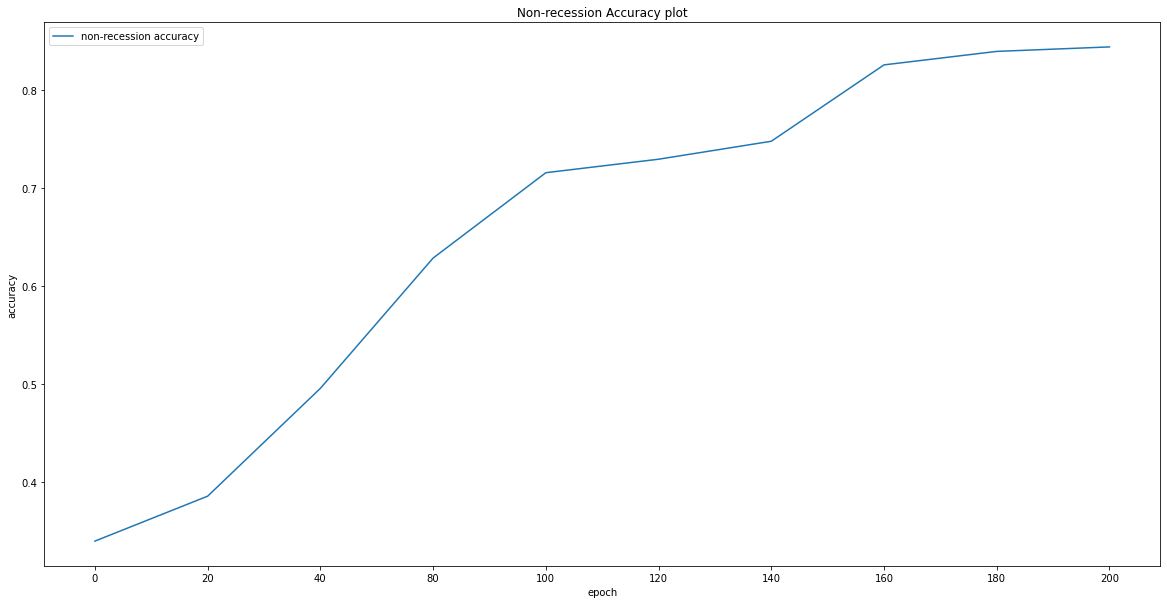

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

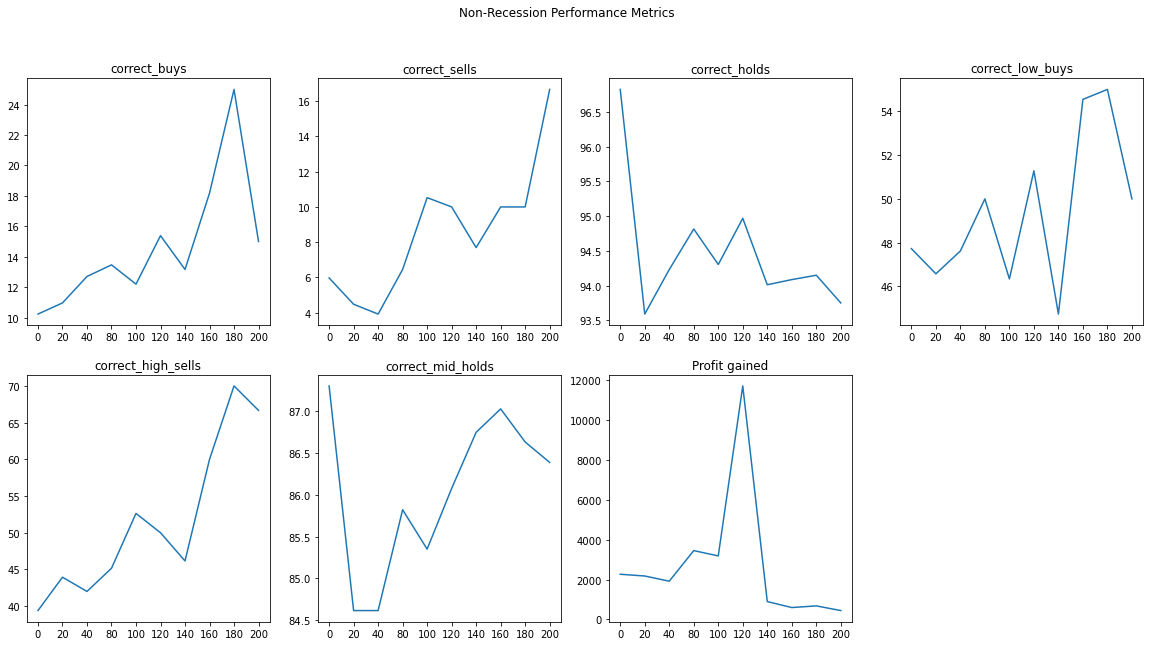

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

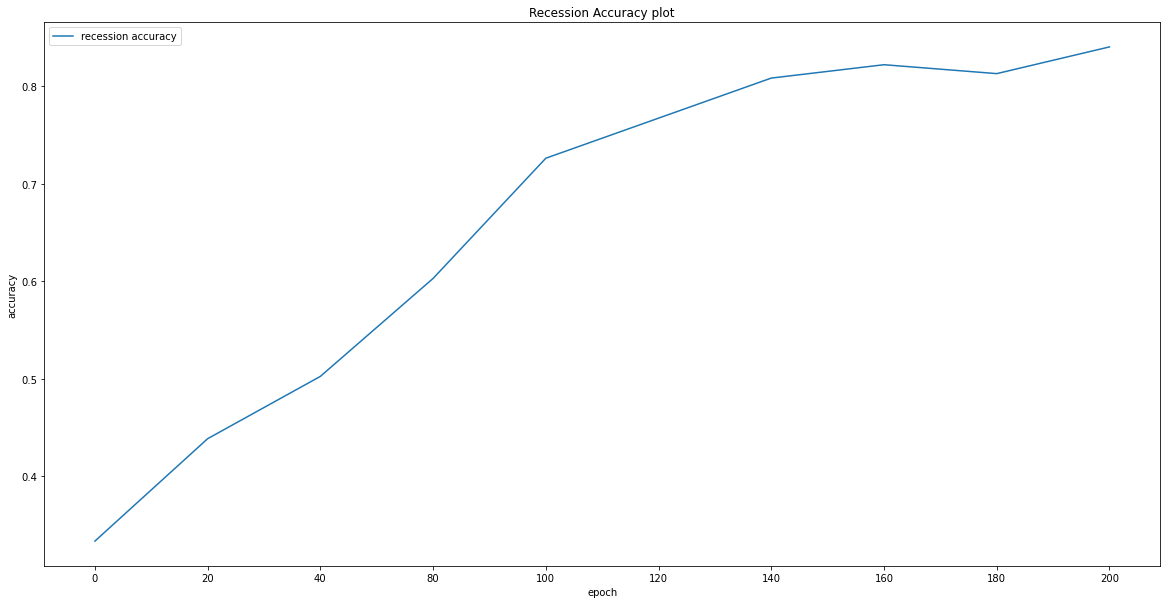

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

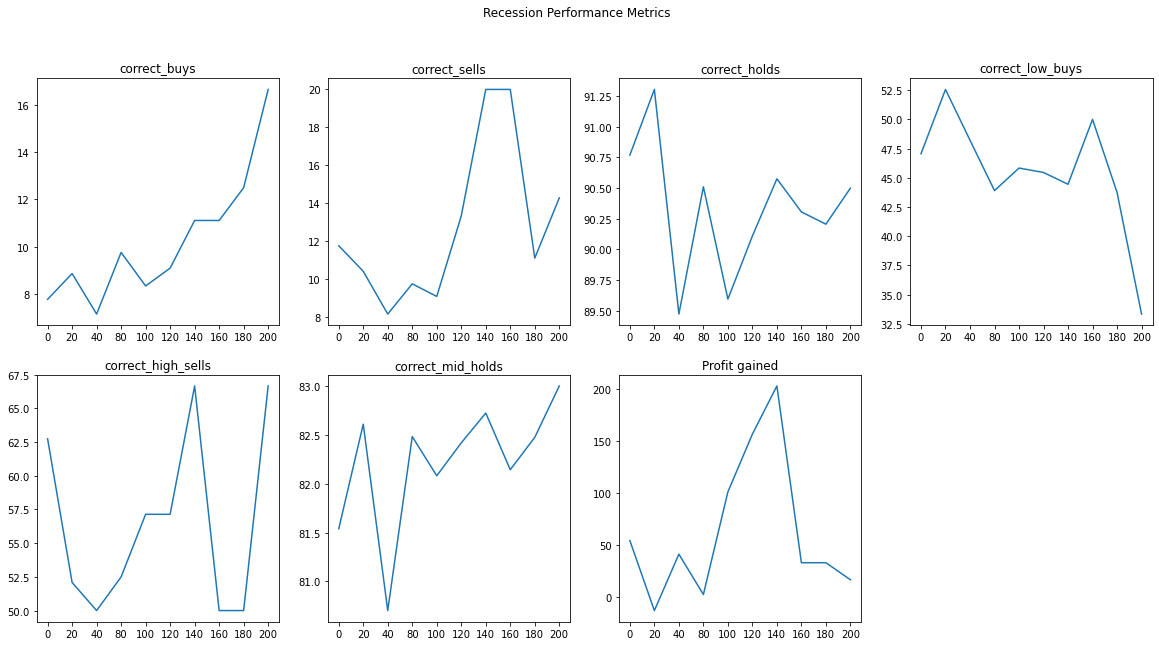

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### American Axle

In [59]:
nr_test_sets = ['AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-12-13        11.52  11.820811 -67.289689  230854400.0     2.0
2018-12-14        11.52  11.774532 -67.289689  230854400.0     2.0
2018-12-17        11.27  11.696912 -78.971930  229177400.0     2.0
2018-12-18        11.25  11.628156 -79.906531  227542600.0     2.0
2018-12-19        11.43  11.597671 -71.495303  229242700.0     2.0


In [60]:
r_test_sets = ['AXL']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1     
        
    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-12-13        11.04  10.136919  -2.162160 -8221900.0     2.0
2019-12-16        10.54  10.198932 -35.467981 -9883500.0     2.0
2019-12-17        10.67  10.271404 -29.064037 -8890800.0     2.0
2019-12-18        10.64  10.328111 -30.541856 -9882500.0     2.0
2019-12-19        10.77  10.396094 -24.137912 -8689200.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


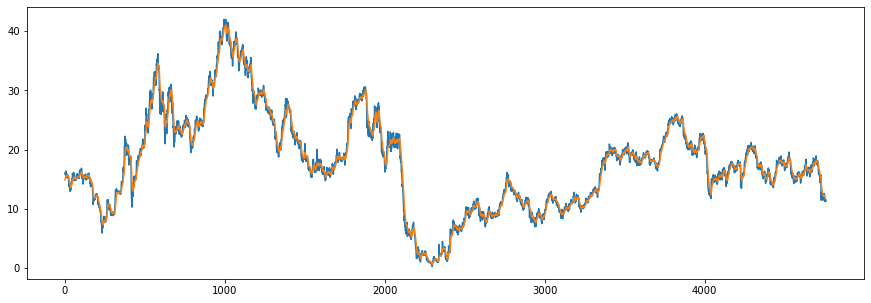

In [61]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/AXL_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

X  = np.array(sequential).reshape(-1, 20, 4)
y = labels
y = np.array(y)

In [62]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [63]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [64]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [66]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('AXL')]
    y = nr_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('AXL'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('AXL')]
    y = r_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('AXL'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.264367816091954, 1: 7.30635838150289, 2: 0.3669085631349782}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 38ms/step - loss: 0.2940 - accuracy: 0.5148 - mse: 0.4557 - weighted_accuracy: 0.3022 - weighted_mse: 0.5308 - val_loss: 0.2990 - val_accuracy: 0.0432 - val_mse: 0.3551 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 0.3551
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2131 - accuracy: 0.4386 - mse: 0.7471 - weighted_accuracy: 0.4238 - weighted_mse: 0.7596 - val_loss: 0.2904 - val_accuracy: 0.0464 - val_mse: 0.3867 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3867
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1939 - accuracy: 0.3064 - mse: 1.0033 - weighted_accuracy: 0.4828 - weighted_mse: 0.9751 - val_loss: 0.2813 - val_accuracy: 0.0464 - val_mse: 0.4288 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4288
Epoch 4/20
30/30 [==============================] - 0s 8ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1911 - accuracy: 0.3379 - mse: 1.3347 - weighted_accuracy: 0.3379 - weighted_mse: 1.3347


<ipython-input-66-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.1910727471113205
Test accuracy: 0.3378995358943939


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 106
actual holds but predicted sell: 29
actual predicted holds: 62
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 3.3333333333333335%
Percentage holds correct: 91.17647058823529%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 50.833333333333336%
Percentage high sells correct: 46.666666666666664%
Percentage mid holds correct: 86.76470588235294%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at the moment: $0.13876689989878344


Price increase from previously bought: -78.82535453671873%
Share price: $0.14684209766810635
Shares owned at the moment: 0
Cash capital at the moment: 

Epoch 18/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1358 - accuracy: 0.4272 - mse: 1.6742 - weighted_accuracy: 0.7059 - weighted_mse: 1.5904 - val_loss: 0.1823 - val_accuracy: 0.4241 - val_mse: 1.6437 - val_weighted_accuracy: 0.4241 - val_weighted_mse: 1.6437
Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1347 - accuracy: 0.4230 - mse: 1.6920 - weighted_accuracy: 0.7263 - weighted_mse: 1.6117 - val_loss: 0.1985 - val_accuracy: 0.3281 - val_mse: 1.7664 - val_weighted_accuracy: 0.3281 - val_weighted_mse: 1.7664
Epoch 20/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1333 - accuracy: 0.4570 - mse: 1.7037 - weighted_accuracy: 0.7369 - weighted_mse: 1.6247 - val_loss: 0.1798 - val_accuracy: 0.4620 - val_mse: 1.7244 - val_weighted_accuracy: 0.4620 - val_weighted_mse: 1.7244
Validation loss: 0.1797698587179184
Validation accuracy: 0.46202531456947327


Non-Recession Test


7/7 [==============================] - 0s 3ms/step 

<ipython-input-66-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 50
actual holds but predicted sell: 60
actual predicted holds: 87
Percentage buys correct: 14.516129032258064%
Percentage sells correct: 4.6875%
Percentage holds correct: 93.54838709677419%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 63.9344262295082%
Percentage high sells correct: 53.125%
Percentage mid holds correct: 88.17204301075269%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at the moment: $0.13876689989878344


Price increase from previously bought: -78.82535453671873%
Share price: $0.14684209766810635
Shares owned at the moment: 0
Cash capital at the moment: $21.225879493429527


Share price: $0.07447368425180377
Shares owned at the moment: 284
Cash 

7/7 [==============================] - 0s 3ms/step - loss: 0.1823 - accuracy: 0.4703 - mse: 1.8779 - weighted_accuracy: 0.4703 - weighted_mse: 1.8779
Test loss: 0.18233036994934082
Test accuracy: 0.47031962871551514


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 4
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 51
actual holds but predicted sell: 53
actual predicted holds: 93
Percentage buys correct: 12.698412698412698%
Percentage sells correct: 3.6363636363636362%
Percentage holds correct: 92.07920792079207%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 59.67741935483871%
Percentage high sells correct: 58.18181818181818%
Percentage mid holds correct: 87.12871287128714%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at the moment: $0.13876689989878344


Pr

<ipython-input-66-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1136 - accuracy: 0.5419 - mse: 2.0717 - weighted_accuracy: 0.8010 - weighted_mse: 2.0421 - val_loss: 0.1686 - val_accuracy: 0.5274 - val_mse: 2.1385 - val_weighted_accuracy: 0.5274 - val_weighted_mse: 2.1385
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1131 - accuracy: 0.5762 - mse: 2.0900 - weighted_accuracy: 0.7989 - weighted_mse: 2.0817 - val_loss: 0.1958 - val_accuracy: 0.4230 - val_mse: 2.1868 - val_weighted_accuracy: 0.4230 - val_weighted_mse: 2.1868
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1124 - accuracy: 0.5461 - mse: 2.1397 - weighted_accuracy: 0.8061 - weighted_mse: 2.1244 - val_loss: 0.1933 - val_accuracy: 0.4357 - val_mse: 2.1464 - val_weighted_accuracy: 0.4357 - val_weighted_mse: 2.1464
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1118 - accuracy: 0.5799 - mse: 2.1426 - weighted_accuracy: 0.8149 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1726 - accuracy: 0.5434 - mse: 2.2000 - weighted_accuracy: 0.5434 - weighted_mse: 2.2000
Test loss: 0.17256537079811096
Test accuracy: 0.543379008769989


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 39
actual holds but predicted sell: 48
actual predicted holds: 110
Percentage buys correct: 14.583333333333334%
Percentage sells correct: 4.0%
Percentage holds correct: 90.9090909090909%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 64.58333333333333%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at the moment: $0.13876689989878344


Price increase from previously b

<ipython-input-66-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu


30/30 [==============================] - 0s 8ms/step - loss: 0.0963 - accuracy: 0.6443 - mse: 2.5649 - weighted_accuracy: 0.8440 - weighted_mse: 2.6131 - val_loss: 0.1619 - val_accuracy: 0.6139 - val_mse: 2.6239 - val_weighted_accuracy: 0.6139 - val_weighted_mse: 2.6239
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0961 - accuracy: 0.6727 - mse: 2.5644 - weighted_accuracy: 0.8562 - weighted_mse: 2.6333 - val_loss: 0.1879 - val_accuracy: 0.5169 - val_mse: 2.6690 - val_weighted_accuracy: 0.5169 - val_weighted_mse: 2.6690
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0953 - accuracy: 0.6427 - mse: 2.6255 - weighted_accuracy: 0.8543 - weighted_mse: 2.6968 - val_loss: 0.1753 - val_accuracy: 0.5696 - val_mse: 2.6174 - val_weighted_accuracy: 0.5696 - val_weighted_mse: 2.6174
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0937 - accuracy: 0.6759 - mse: 2.6342 - weighted_accuracy: 0.8665 - weighted_mse: 2.6981 -

7/7 [==============================] - 0s 3ms/step - loss: 0.1633 - accuracy: 0.5845 - mse: 2.6735 - weighted_accuracy: 0.5845 - weighted_mse: 2.6735
Test loss: 0.16327877342700958
Test accuracy: 0.5844748616218567


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 37
actual holds but predicted sell: 37
actual predicted holds: 123
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 2.6315789473684212%
Percentage holds correct: 88.48920863309353%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 64.28571428571429%
Percentage high sells correct: 57.89473684210526%
Percentage mid holds correct: 84.05797101449275%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at the moment: $0.13876689989878344


Pri

<ipython-input-66-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0797 - accuracy: 0.7358 - mse: 3.1786 - weighted_accuracy: 0.8921 - weighted_mse: 3.2852 - val_loss: 0.1498 - val_accuracy: 0.6909 - val_mse: 3.3554 - val_weighted_accuracy: 0.6909 - val_weighted_mse: 3.3554
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0793 - accuracy: 0.7582 - mse: 3.2134 - weighted_accuracy: 0.9022 - weighted_mse: 3.3391 - val_loss: 0.1828 - val_accuracy: 0.5876 - val_mse: 3.3883 - val_weighted_accuracy: 0.5876 - val_weighted_mse: 3.3883
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0800 - accuracy: 0.7371 - mse: 3.2854 - weighted_accuracy: 0.8871 - weighted_mse: 3.4270 - val_loss: 0.1682 - val_accuracy: 0.6466 - val_mse: 3.4297 - val_weighted_accuracy: 0.6466 - val_weighted_mse: 3.4297
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0782 - accuracy: 0.7482 - mse: 3.2948 - weighted_accuracy: 0.9021 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1700 - accuracy: 0.6073 - mse: 3.2392 - weighted_accuracy: 0.6073 - weighted_mse: 3.2392
Test loss: 0.16998881101608276
Test accuracy: 0.6073059439659119


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 32
actual holds but predicted sell: 38
actual predicted holds: 127
Percentage buys correct: 10.81081081081081%
Percentage sells correct: 5.0%
Percentage holds correct: 89.43661971830986%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.054054054054056%
Percentage high sells correct: 57.5%
Percentage mid holds correct: 83.68794326241135%


Capital: 100
Share price: $0.7323683459689425
Shares owned at the moment: 136
Cash capital at the moment: $0.1239991868314263


Price increase from previously 

<ipython-input-66-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0659 - accuracy: 0.8022 - mse: 4.0074 - weighted_accuracy: 0.9201 - weighted_mse: 4.1209 - val_loss: 0.1577 - val_accuracy: 0.6920 - val_mse: 4.1495 - val_weighted_accuracy: 0.6920 - val_weighted_mse: 4.1495
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0651 - accuracy: 0.8109 - mse: 4.0314 - weighted_accuracy: 0.9215 - weighted_mse: 4.1502 - val_loss: 0.1857 - val_accuracy: 0.6329 - val_mse: 4.3417 - val_weighted_accuracy: 0.6329 - val_weighted_mse: 4.3417
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0664 - accuracy: 0.7983 - mse: 4.0918 - weighted_accuracy: 0.9078 - weighted_mse: 4.2361 - val_loss: 0.1762 - val_accuracy: 0.6677 - val_mse: 4.4442 - val_weighted_accuracy: 0.6677 - val_weighted_mse: 4.4442
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0664 - accuracy: 0.7959 - mse: 4.1038 - weighted_accuracy: 0.9196 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1688 - accuracy: 0.7123 - mse: 3.9431 - weighted_accuracy: 0.7123 - weighted_mse: 3.9431
Test loss: 0.16879716515541077
Test accuracy: 0.7123287916183472


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 2


<ipython-input-66-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

actual sells but predicted hold: 8
actual holds but predicted buy: 19
actual holds but predicted sell: 28
actual predicted holds: 150
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 90.9090909090909%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 85.97560975609755%


Capital: 100
Share price: $0.7323683459689425
Shares owned at the moment: 136
Cash capital at the moment: $0.1239991868314263


Price increase from previously bought: -75.70461170128459%
Share price: $0.17842104569696665
Shares owned at the moment: 0
Cash capital at the moment: $24.322531930528225


Share price: $0.18894735124963175
Shares owned at the moment: 128
Cash capital at the moment: $0.07076150293548977


Price increase from previously bought: 128.89701423732362%
Share price: $0.4336842063160155
Shares owned at the moment: 0
Cash capital at 

<ipython-input-66-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 8ms/step - loss: 0.0458 - accuracy: 0.8732 - mse: 6.0944 - weighted_accuracy: 0.9480 - weighted_mse: 6.0064 - val_loss: 0.1823 - val_accuracy: 0.7532 - val_mse: 6.2534 - val_weighted_accuracy: 0.7532 - val_weighted_mse: 6.2534
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0450 - accuracy: 0.8821 - mse: 6.1264 - weighted_accuracy: 0.9513 - weighted_mse: 6.0083 - val_loss: 0.1929 - val_accuracy: 0.7310 - val_mse: 6.8025 - val_weighted_accuracy: 0.7310 - val_weighted_mse: 6.8025
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0469 - accuracy: 0.8671 - mse: 6.2258 - weighted_accuracy: 0.9439 - weighted_mse: 6.1729 - val_loss: 0.2032 - val_accuracy: 0.7247 - val_mse: 6.9709 - val_weighted_accuracy: 0.7247 - val_weighted_mse: 6.9709
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0491 - accuracy: 0.8613 - mse: 6.1503 - weighted_accuracy: 0.9436 - weighted_mse: 6.1170 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1889 - accuracy: 0.7260 - mse: 5.9886 - weighted_accuracy: 0.7260 - weighted_mse: 5.9886
Test loss: 0.18891163170337677
Test accuracy: 0.7260273694992065


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 11
actual holds but predicted sell: 28
actual predicted holds: 158
Percentage buys correct: 0.0%
Percentage sells correct: 3.4482758620689653%
Percentage holds correct: 88.76404494382022%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 55.172413793103445%
Percentage mid holds correct: 84.18079096045197%


Capital: 100
Share price: $0.4915789495974036
Shares owned at the moment: 202
Cash capital at the moment: $0.42798007482311107


Price increase from previous

<ipython-input-66-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0384 - accuracy: 0.8929 - mse: 7.3547 - weighted_accuracy: 0.9571 - weighted_mse: 7.0628 - val_loss: 0.1981 - val_accuracy: 0.7795 - val_mse: 7.5851 - val_weighted_accuracy: 0.7795 - val_weighted_mse: 7.5851
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0367 - accuracy: 0.9056 - mse: 7.4045 - weighted_accuracy: 0.9635 - weighted_mse: 7.0824 - val_loss: 0.2091 - val_accuracy: 0.7637 - val_mse: 8.2363 - val_weighted_accuracy: 0.7637 - val_weighted_mse: 8.2363
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0385 - accuracy: 0.8964 - mse: 7.5321 - weighted_accuracy: 0.9547 - weighted_mse: 7.2700 - val_loss: 0.2077 - val_accuracy: 0.7700 - val_mse: 8.5330 - val_weighted_accuracy: 0.7700 - val_weighted_mse: 8.5330
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0406 - accuracy: 0.8890 - mse: 7.4776 - weighted_accuracy: 0.9574 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1956 - accuracy: 0.7443 - mse: 7.0783 - weighted_accuracy: 0.7443 - weighted_mse: 7.0783
Test loss: 0.19562405347824097
Test accuracy: 0.7442922592163086


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 12
actual holds but predicted sell: 23
actual predicted holds: 162
Percentage buys correct: 0.0%
Percentage sells correct: 4.166666666666667%
Percentage holds correct: 89.01098901098901%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 46.15384615384615%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 83.97790055248619%


Capital: 100
Share price: $0.4915789495974036
Shares owned at the moment: 202
Cash capital at the moment: $0.42798007482311107


Price increase f

<ipython-input-66-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

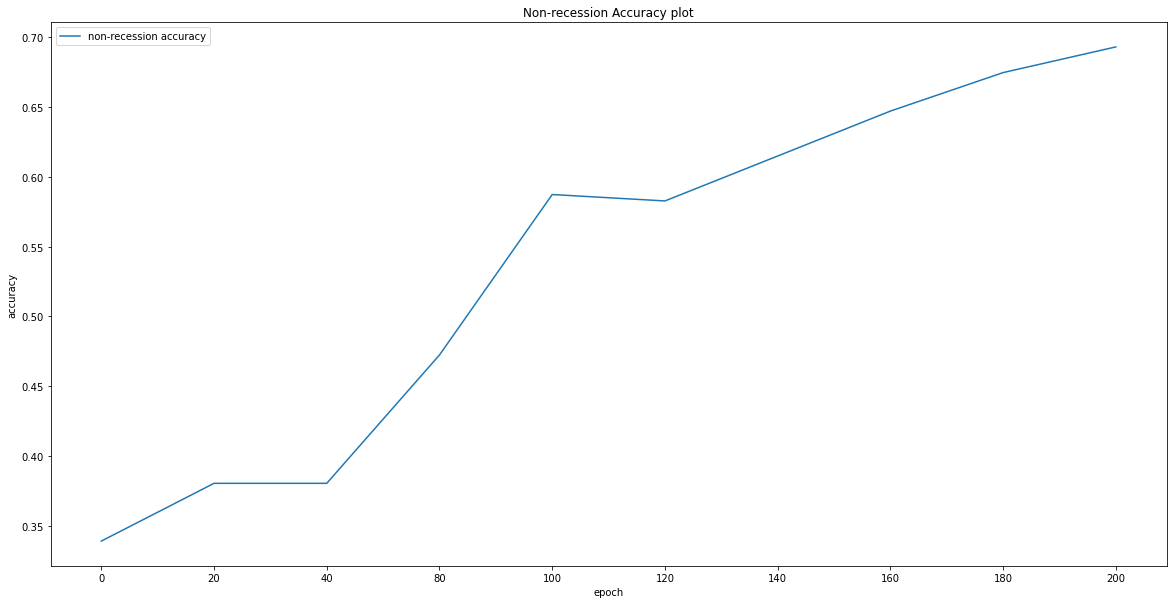

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

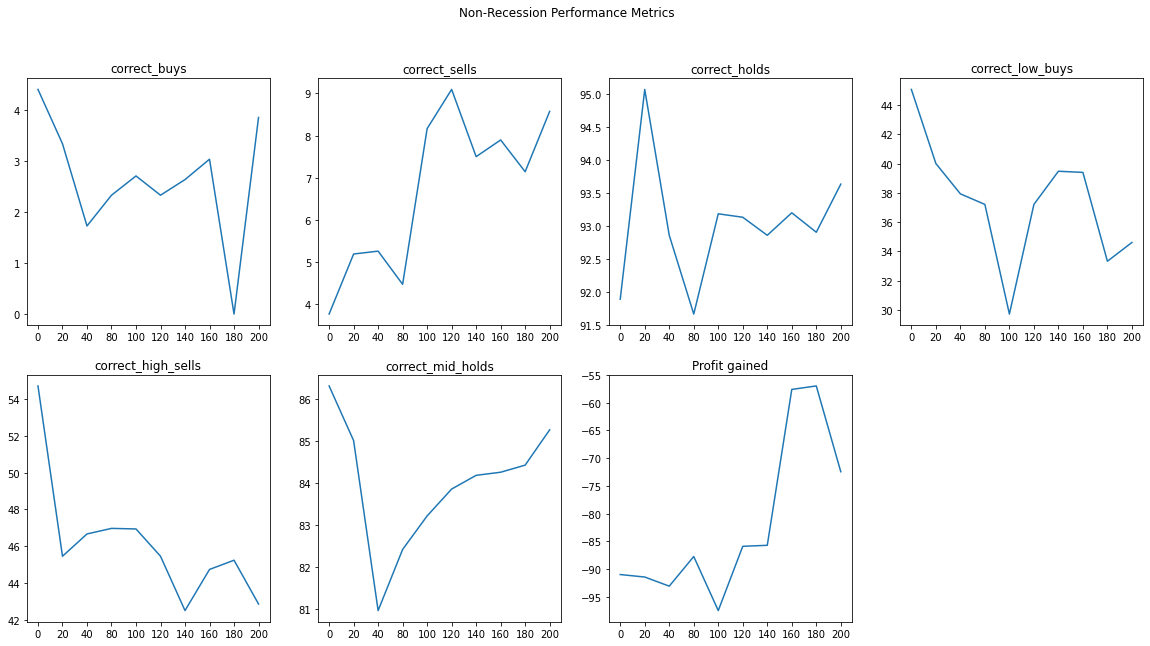

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

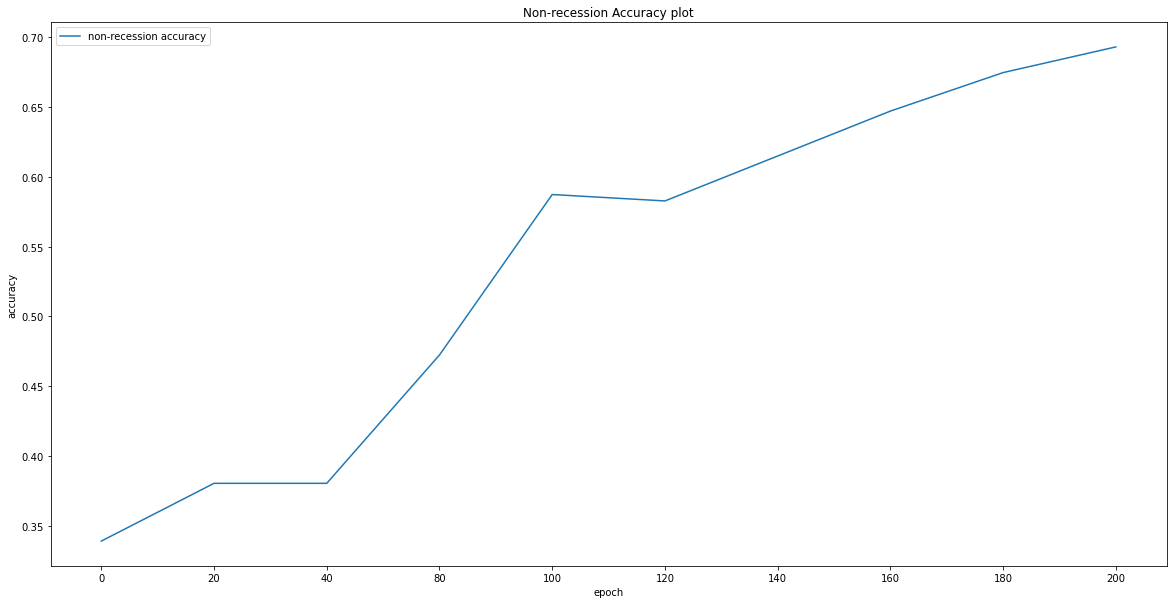

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

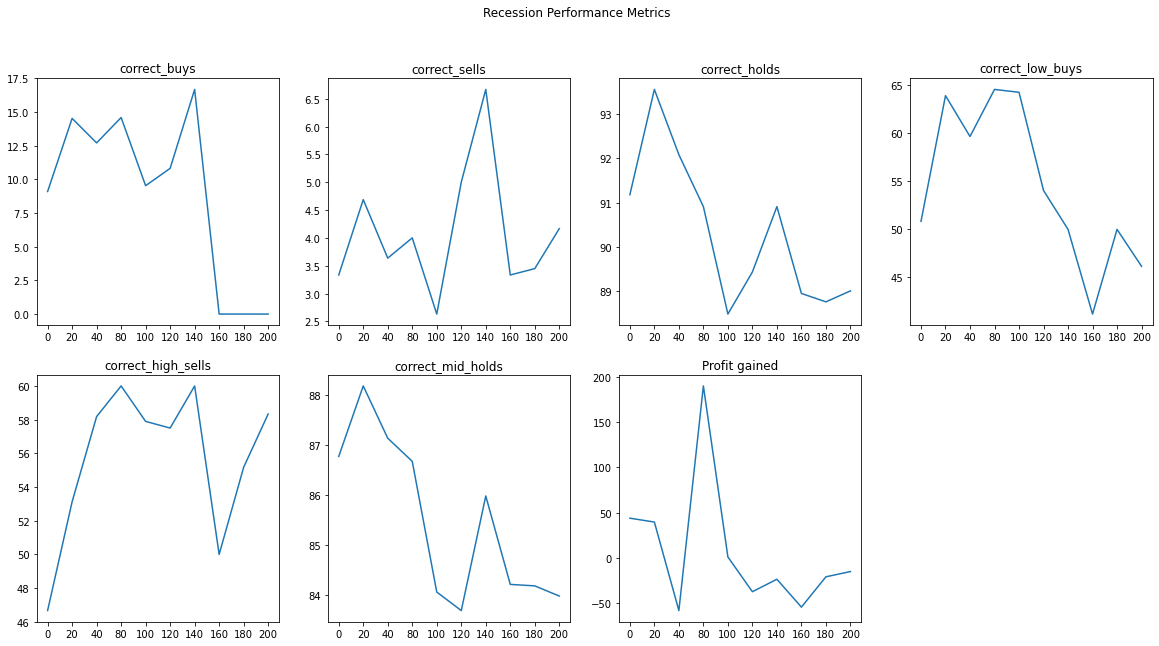

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")